In [49]:
import pandas as pd
from datetime import datetime
from sklearn.metrics import jaccard_score
import time

In [2]:
data = pd.read_csv('bank_transactions.csv')
data.head(10)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50
5,T6,C1536588,8/10/72,F,ITANAGAR,53609.20,2/8/16,173940,676.00
6,T7,C7126560,26/1/92,F,MUMBAI,973.46,2/8/16,173806,566.00
7,T8,C1220223,27/1/82,M,MUMBAI,95075.54,2/8/16,170537,148.00
8,T9,C8536061,19/4/88,F,GURGAON,14906.96,2/8/16,192825,833.00
9,T10,C6638934,22/6/84,M,MUMBAI,4279.22,2/8/16,192446,289.11


# 1. Finding Similar Costumers

## 1. Parsing and pre-processing the datetime objects

In [3]:
# number of rows before dropping the NA
data.shape

(1048567, 9)

In [4]:
# drop all missing values - they are not that many 
data.dropna(inplace=True)

In [5]:
# visualizing how many rows we dropped
data.shape[0]

1041614

In [6]:
# drop all missing values - they are not that many 
data.dropna(inplace=True)

In [7]:
# handling dates
data.CustomerDOB = pd.to_datetime(data.CustomerDOB)

In [8]:
data.TransactionDate = pd.to_datetime(data.TransactionDate)

<AxesSubplot:>

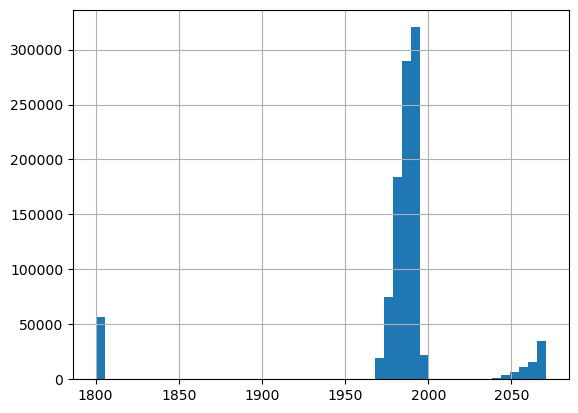

In [9]:
# we can visualize the outliers
data.CustomerDOB.dt.year.hist(bins=50)

We decide to manage the outliers in this way: 
>- dropping the customers born in the 19th century
>- translating of 100 years the too young customers

In [10]:
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
# drop the customers that have year = 1800
data.drop(data[data.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

<AxesSubplot:>

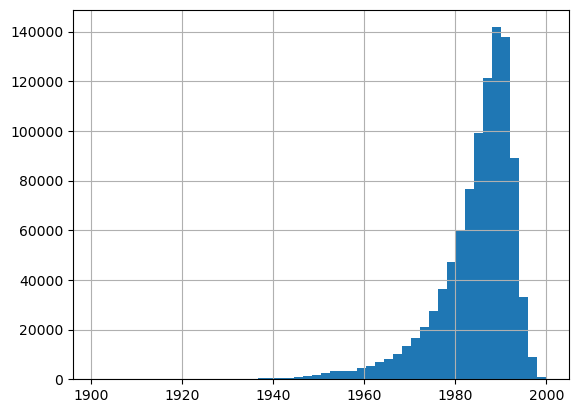

In [11]:
data.CustomerDOB.dt.year.hist(bins=50)

In [22]:
# handling the issue of the 'TransactionTime' column in a strange format
data.TransactionTime = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S').time())

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985322 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            985322 non-null  object        
 1   CustomerID               985322 non-null  object        
 2   CustomerDOB              985322 non-null  datetime64[ns]
 3   CustGender               985322 non-null  object        
 4   CustLocation             985322 non-null  object        
 5   CustAccountBalance       985322 non-null  float64       
 6   TransactionDate          985322 non-null  datetime64[ns]
 7   TransactionTime          985322 non-null  int64         
 8   TransactionAmount (INR)  985322 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 75.2+ MB


#### EDA
Analysis of the transactions in the data set

<AxesSubplot:>

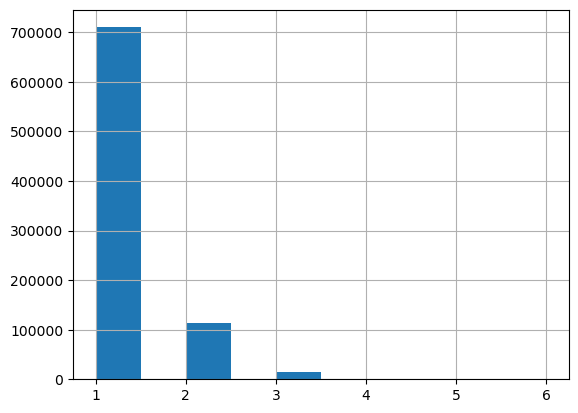

In [13]:
data.groupby('CustomerID').TransactionID.count().hist()

In [26]:
transPerCust = data.groupby('CustomerID').count()

In [27]:
transPerCust.head(10)

,TransactionID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
CustomerID,,,,,,,,
C1010011,2,2,2,2,2,2,2,2
C1010012,1,1,1,1,1,1,1,1
C1010014,2,2,2,2,2,2,2,2
C1010018,1,1,1,1,1,1,1,1
C1010024,1,1,1,1,1,1,1,1
C1010028,1,1,1,1,1,1,1,1
C1010031,2,2,2,2,2,2,2,2
C1010035,2,2,2,2,2,2,2,2
C1010036,1,1,1,1,1,1,1,1


In [ ]:
data.groupby('CustomerID').TransactionID.count().sort_values()

CustomerID
C5031144    1
C6142728    1
C6142735    1
C6142737    1
C6142746    1
           ..
C1026833    6
C6735477    6
C6624352    6
C1736254    6
C3226689    6
Name: TransactionID, Length: 839081, dtype: int64

In [23]:
# Customers with the same CustomerID have different attributes
data[data.CustomerID == 'C3226689']

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
19882,T19883,C3226689,1990-01-01,M,BASTI,11369.40,2016-09-26,13:13:42,200.00
35613,T35614,C3226689,1987-09-15,M,NOIDA,96820.46,2016-09-30,14:50:16,418.00
218661,T218662,C3226689,1984-04-11,F,NEW DELHI,1667.83,2016-08-08,19:02:33,4700.00
756541,T756542,C3226689,1972-09-17,M,SHARJAH,588826.94,2016-01-09,16:55:54,6351.39
836123,T836124,C3226689,1977-07-20,M,THANE,369.36,2016-04-09,13:46:45,1749.00
984048,T984049,C3226689,1985-05-21,M,GURGAON,12977.22,2016-09-15,19:59:29,1340.00


There is a mistake here?... NO, probably we have different customers related to the same account (for instance a family account).

# 1.2 Fingerprint hashing

### MinHash

We would like to identify a certain number of customer categories. To do that we proceed in this way:

1. we notice that not all over the features are useful to identify a customer category -> we do not consider attributes TransactionID and CustomerID for customer profiling (CustomerID is not representative since it can probably refer to different customers that share the same account... we'll comment later);

2. we have to apply an hash function before the min hash, mapping the elements of a type different from an integer into integers;

3. we define the hash functions (in a randomic but deterministic way) that we'll use to find the minhash signature

4. we define and identify the number of categories in which map the whole set of customers.


1. Choosing the features to characterize a single customer

In [14]:
data_small = data.iloc[:,2:]
data_small.head(6)

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0
1,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0
2,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0
3,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0
4,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5
5,1972-08-10,F,ITANAGAR,53609.20,2016-02-08,173940,676.0


2. Hashing the elements of each columns of the dataframe (i.e. each faeture value) into an integer that will represent the input of the min_hash function. Note that for our task we want to leave the 'TransactionTime' attribute in integer form without mapping it in a datetime.time object.

In [15]:
# a hash function that converts all values in the dataframe to integers

def hash_func(variable):

    # for the elemnts of TransactionDate and CustomerDOB
    if isinstance(variable, pd._libs.tslibs.timestamps.Timestamp):
        return variable.year*10000 + variable.month*100 + variable.day

    # for the elements of CustAccountBalance and TransactionAmount(INR)
    elif isinstance(variable, float):
        return int(variable)

    # for the elements of CustLocation and CustGender
    elif isinstance(variable, str):
        return hash_string(variable)
    return variable


# function that converts a string to an integer
def hash_string(var):
    m = 2**32
    p = 31
    s = 0
    
    for i in range(len(var)):
        s += ord(var[i])*(p**i)
        
    return s % m

3. Now we define the "random" hashing functions and the minhash algorithm

In [16]:
from random import randint

# length of each minhash vector
N = 100
max_val = (2**32)-1

# create N tuples that will serve as permutation functions
# these permutation values are used to hash all input sets
perms = [ (randint(0,max_val), randint(0,max_val)) for i in range(N)]

In [17]:
import numpy as np

def minhash(row, p=125539, perms = perms):
    
    # initialize a minhash of length N with positive infinity values
    vec = [float(np.inf) for i in range(N)]

    for i, feat in row.iteritems():

        # ensure s is composed of integers
        value = hash_func(feat)

        #loop over each "permutation function"
        for perm_i, perm_vals in enumerate(perms):
            a, b = perm_vals

            # pass `val` through the `ith` permutation function
            output = (a * value + b) % p
            #print(output)
            # conditionally update the `ith` value of vec
            if vec[perm_i] > output:
                vec[perm_i] = output

    # the returned vector represents the minimum hash of the set s
    return(vec)

In [18]:
data_small['minhash'] = [minhash(row, p=125539, perms=perms) for i,row in data_small.iterrows()]

In [85]:
# saving the new data frame with the minhash signature in a csv file
data_small.to_csv('minhash_data.csv')

In [51]:
data_minhash = pd.read_csv('minhash_data.csv')

In [19]:
data_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985322 entries, 0 to 1048566
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CustomerDOB              985322 non-null  datetime64[ns]
 1   CustGender               985322 non-null  object        
 2   CustLocation             985322 non-null  object        
 3   CustAccountBalance       985322 non-null  float64       
 4   TransactionDate          985322 non-null  datetime64[ns]
 5   TransactionTime          985322 non-null  int64         
 6   TransactionAmount (INR)  985322 non-null  float64       
 7   minhash                  985322 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 67.7+ MB


### Bending technique

In the code cell below we implement our version of bending technique.

The _divide_bands_ function takes as input a vector (python list) of integers and divide the input in subvectors of length _n-elem_, building up a list of lists.

The output is a dictionary with the indexes of the subvectors as keys and subvectors themselves as values.

In [22]:
from collections import defaultdict

# define the number pf bands in which I want to divide the minhash signature
band = 5
n_elem = 20

def divide_bands(minhash, n_elem, band):
    
    new_min = []
    j = 0
    for i in range(0,len(minhash)+1,n_elem):
        if i == 0:
            continue
        else:
            new_min.append(minhash[i-n_elem: i])
        
    return new_min

In [23]:
# building a copy of our data frame with the minhash signatures in order to implement the LSH
data_lsh = data_small.copy()
data_lsh

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),minhash
0,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0,"[12049, 1069, 8964, 6150, 3546, 3565, 19855, 1..."
1,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0,"[10837, 13735, 1924, 4596, 2268, 28888, 17551,..."
2,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0,"[2441, 1069, 16763, 6150, 6185, 6305, 3671, 17..."
3,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0,"[10902, 1069, 39469, 6150, 6185, 12982, 34279,..."
4,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5,"[9517, 1069, 11201, 6150, 760, 16274, 34279, 1..."
...,...,...,...,...,...,...,...,...
1048562,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,184824,799.0,"[9156, 32314, 1924, 33340, 2268, 12958, 3042, ..."
1048563,1992-02-20,M,NASHIK,27311.42,2016-09-18,183734,460.0,"[8472, 41193, 1924, 7775, 2268, 2800, 3718, 27..."
1048564,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,183313,770.0,"[21484, 26515, 1924, 2444, 2268, 57422, 17551,..."
1048565,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,184706,1000.0,"[38417, 822, 1924, 20430, 2268, 53219, 17551, ..."


In [27]:
data_lsh['minhash'] = data_lsh['minhash'].apply(lambda row: divide_bands(row, n_elem, band))
data_lsh

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),minhash
0,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0,"[[12049, 1069, 8964, 6150, 3546, 3565, 19855, ..."
1,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0,"[[10837, 13735, 1924, 4596, 2268, 28888, 17551..."
2,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0,"[[2441, 1069, 16763, 6150, 6185, 6305, 3671, 1..."
3,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0,"[[10902, 1069, 39469, 6150, 6185, 12982, 34279..."
4,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5,"[[9517, 1069, 11201, 6150, 760, 16274, 34279, ..."
...,...,...,...,...,...,...,...,...
1048562,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,184824,799.0,"[[9156, 32314, 1924, 33340, 2268, 12958, 3042,..."
1048563,1992-02-20,M,NASHIK,27311.42,2016-09-18,183734,460.0,"[[8472, 41193, 1924, 7775, 2268, 2800, 3718, 2..."
1048564,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,183313,770.0,"[[21484, 26515, 1924, 2444, 2268, 57422, 17551..."
1048565,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,184706,1000.0,"[[38417, 822, 1924, 20430, 2268, 53219, 17551,..."


# 1.3 Locality Sensitive Hashing

### Banding tachnique and naming buckets

Now for each band we use a new hash function that takes in input vectors of _r_ integers (_r_: number of elements of each subvector after the division in bands) and hashes them to some large number of buckets.

In [28]:
# this function takes as input a minhash signature and returns the bucket names to which each subvector of the signature is hashed
# notice that in naming the buckets we do consider the the correspondent position of each subvector
# in this way we have different buckets for same vectors in different buckets

def bucket_names(row):
    bucket_names = []
    i = 0
    for v in row:
        name = str(i)
        name += "".join([str(x) for x in v])
        bucket_names.append(name)
        i += 1
    
    return bucket_names

We apply our hash function to each row of our data frame in order to find buckets to which the row itself is linked.

In [29]:
data_lsh['bucket_names'] = data_lsh['minhash'].apply(lambda row: bucket_names(row))
data_lsh

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),minhash,bucket_names
0,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0,"[[12049, 1069, 8964, 6150, 3546, 3565, 19855, ...",[012049106989646150354635651985513009393651098...
1,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0,"[[10837, 13735, 1924, 4596, 2268, 28888, 17551...",[010837137351924459622682888817551888886242341...
2,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0,"[[2441, 1069, 16763, 6150, 6185, 6305, 3671, 1...",[024411069167636150618563053671170114815240962...
3,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0,"[[10902, 1069, 39469, 6150, 6185, 12982, 34279...",[010902106939469615061851298234279130091481524...
4,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5,"[[9517, 1069, 11201, 6150, 760, 16274, 34279, ...",[095171069112016150760162743427913009157967935...
...,...,...,...,...,...,...,...,...,...
1048562,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,184824,799.0,"[[9156, 32314, 1924, 33340, 2268, 12958, 3042,...",[091563231419243334022681295830421080623946529...
1048563,1992-02-20,M,NASHIK,27311.42,2016-09-18,183734,460.0,"[[8472, 41193, 1924, 7775, 2268, 2800, 3718, 2...",[084724119319247775226828003718275389352341023...
1048564,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,183313,770.0,"[[21484, 26515, 1924, 2444, 2268, 57422, 17551...",[021484265151924244422685742217551604244184245...
1048565,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,184706,1000.0,"[[38417, 822, 1924, 20430, 2268, 53219, 17551,...",[038417822192420430226853219175518817239467384...


### Pre-processing and adjusting the query data set

We have to pre-process the query data set in the same way we pre-processed tha main data set 

In [30]:
query = pd.read_csv('query_users.csv')
query.head(10)

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,27/7/78,M,DELHI,94695.61,2/9/16,140310,65.0
1,6/11/92,M,PANCHKULA,7584.09,2/9/16,120214,6025.0
2,14/8/91,M,PATNA,7180.60,10/8/16,221732,541.5
3,3/1/87,M,CHENNAI,56847.75,29/8/16,144138,1000.0
4,4/1/95,M,GURGAON,84950.13,25/9/16,233309,80.0
5,10/1/81,M,WORLD TRADE CENTRE BANGALORE,23143.95,11/9/16,192906,303.0
6,20/9/76,F,CHITTOOR,15397.80,28/8/16,92633,20.0
7,10/4/91,M,MOHALI,426.30,2/8/16,203754,50.0
8,19/3/90,M,MOHALI,4609.34,26/8/16,184015,300.0
9,19/12/70,M,SERAMPORE,6695988.46,27/8/16,144030,299.0


In [31]:
# drop all missing values - they are not that many 
query.dropna(inplace=True)

In [32]:
# visualizing how many rows we dropped
query.shape[0]

50

In [33]:
# handling dates
query.CustomerDOB = pd.to_datetime(query.CustomerDOB)

In [34]:
query.TransactionDate = pd.to_datetime(query.TransactionDate)

In [35]:
query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CustomerDOB              50 non-null     datetime64[ns]
 1   CustGender               50 non-null     object        
 2   CustLocation             50 non-null     object        
 3   CustAccountBalance       50 non-null     float64       
 4   TransactionDate          50 non-null     datetime64[ns]
 5   TransactionTime          50 non-null     int64         
 6   TransactionAmount (INR)  50 non-null     float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(2)
memory usage: 2.9+ KB


In [36]:
query['minhash'] = [minhash(row, p=125539, perms=perms) for i,row in query.iterrows()]

In [37]:
query['minhash'] = query['minhash'].apply(lambda row: divide_bands(row, n_elem, band))
query['bucket_names'] = query['minhash'].apply(lambda row: bucket_names(row))
query

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),minhash,bucket_names
0,1978-07-27,M,DELHI,94695.61,2016-02-09,140310,65.00,"[[38417, 43860, 1924, 25638, 2268, 2332, 17551...",[038417438601924256382268233217551312444157819...
1,1992-06-11,M,PANCHKULA,7584.09,2016-02-09,120214,6025.00,"[[34111, 252, 1924, 3717, 2268, 6633, 11191, 4...",[034111252192437172268663311191435111712341066...
2,1991-08-14,M,PATNA,7180.60,2016-10-08,221732,541.50,"[[32579, 45427, 1924, 17400, 2268, 347, 12742,...",[032579454271924174002268347127423275435018841...
3,1987-03-01,M,CHENNAI,56847.75,2016-08-29,144138,1000.00,"[[32684, 5282, 1924, 34764, 2268, 9247, 7245, ...",[032684528219243476422689247724519460110872496...
4,1995-04-01,M,GURGAON,84950.13,2016-09-25,233309,80.00,"[[9346, 3568, 1924, 9136, 2268, 36784, 7203, 5...",[093463568192491362268367847203529842856814772...
5,1981-10-01,M,WORLD TRADE CENTRE BANGALORE,23143.95,2016-11-09,192906,303.00,"[[3311, 3391, 1924, 3785, 2268, 8146, 307, 188...",[033113391192437852268814630718822945126224018...
6,1976-09-20,F,CHITTOOR,15397.80,2016-08-28,92633,20.00,"[[6387, 1069, 2445, 31963, 2154, 18748, 5541, ...",[063871069244531963215418748554187164437425948...
7,1991-10-04,M,MOHALI,426.30,2016-02-08,203754,50.00,"[[1278, 15579, 1924, 6150, 1916, 11307, 527, 4...",[012781557919246150191611307527463227938524124...
8,1990-03-19,M,MOHALI,4609.34,2016-08-26,184015,300.00,"[[1278, 431, 1924, 16371, 2268, 31117, 10648, ...",[012784311924163712268311171064850536147461556...
9,2070-12-19,M,SERAMPORE,6695988.46,2016-08-27,144030,299.00,"[[2480, 38378, 1924, 8682, 2268, 19758, 5706, ...",[024803837819248682226819758570619261122801654...


### Checking for similarity

Now we can implement a function that evaluates the jaccard similarities between the bucket names of two different rows (elements of our data set).

The function below simply returns the most similar user from the original data set when compared with a user from the query data set 

In [62]:
def jaccard(s1, s2):
    return len(s1.intersection(s2))/len(s1.union(s2))

def most_sim(query_row,df):

    qbuckets = set(query_row['bucket_names'])
    jaccards = {i: jaccard(qbuckets,set(row['bucket_names'])) for i,row in df.iterrows()}
    jaccards = {k: v for k, v in sorted(jaccards.items(), key=lambda item: -item[1])}
    results = list(jaccards.items())
    return results[0]

In [43]:
data_lsh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985322 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CustomerDOB              985322 non-null  datetime64[ns]
 1   CustGender               985322 non-null  object        
 2   CustLocation             985322 non-null  object        
 3   CustAccountBalance       985322 non-null  float64       
 4   TransactionDate          985322 non-null  datetime64[ns]
 5   TransactionTime          985322 non-null  int64         
 6   TransactionAmount (INR)  985322 non-null  float64       
 7   minhash                  985322 non-null  object        
 8   bucket_names             985322 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 75.2+ MB


In this example that we report we can clearly see that the most similar user in the original data set is the user itslef. Indeed we show that the two rows have exactly the same attributes (values of every column). In this way we satisfy the fact that the same objects are hashed to the same sequence of buckets.

In [63]:
most_sim(query.iloc[0], data_lsh)

(747502, 1.0)

In [45]:
data_lsh.loc[747502]

CustomerDOB                                              1978-07-27 00:00:00
CustGender                                                                 M
CustLocation                                                           DELHI
CustAccountBalance                                                  94695.61
TransactionDate                                          2016-02-09 00:00:00
TransactionTime                                                       140310
TransactionAmount (INR)                                                 65.0
minhash                    [[38417, 43860, 1924, 25638, 2268, 2332, 17551...
bucket_names               [038417438601924256382268233217551312444157819...
Name: 747502, dtype: object

In [46]:
query.iloc[0]

CustomerDOB                                              1978-07-27 00:00:00
CustGender                                                                 M
CustLocation                                                           DELHI
CustAccountBalance                                                  94695.61
TransactionDate                                          2016-02-09 00:00:00
TransactionTime                                                       140310
TransactionAmount (INR)                                                 65.0
minhash                    [[38417, 43860, 1924, 25638, 2268, 2332, 17551...
bucket_names               [038417438601924256382268233217551312444157819...
Name: 0, dtype: object

Then we implement another function that checks for similarity for each of the users in the query data set and returns the users with the higher score in terms of Jaccard similarity.

In [69]:
def ranking(query_df, original_df):
    results = [most_sim(query.iloc[i], original_df) for i,row in query_df.iterrows()]
    max_rank = max([score[1] for score in results])
    return [row for row in results if row[1]==max_rank]


In [70]:
start = time.time()
res = ranking(query, data_lsh)
end = time.time()
print(f'The algorithm took {end-start} seconds to run')

The algorithm took 1278.6251754760742 seconds to run


In [73]:
res

[(747502, 1.0),
 (729233, 1.0),
 (315449, 1.0),
 (640748, 1.0),
 (11626, 1.0),
 (937293, 1.0),
 (619274, 1.0),
 (79635, 1.0),
 (600251, 1.0),
 (126684, 1.0),
 (294910, 1.0),
 (569694, 1.0),
 (278321, 1.0),
 (930242, 1.0),
 (153595, 1.0),
 (862574, 1.0),
 (59641, 1.0),
 (539444, 1.0),
 (298056, 1.0),
 (82521, 1.0),
 (166459, 1.0),
 (6846, 1.0),
 (851715, 1.0),
 (221234, 1.0),
 (252011, 1.0),
 (844799, 1.0),
 (936305, 1.0)]

Let us briefly comment on the results obtained above by noting that all rows that have maximum score have a Jaccard similarity of 1. This indicates that we have (as the implemented hash functions minimize the number of collisions) an identity relationship between many rows in the query data set and the original data set.

# 2. Grouping customers together!
Now we will deal with clustering algorithms that will provide groups of clients which are similar among them.

To solve this task, you must accomplish the following stages:

## 2.1 Getting your data + feature engineering
2.Sometimes, the features (variables, fields) are not given in a dataset but can be created from it. The previous step is known as feature engineering. For example, the original dataset has several transactions done by the same customer. Then, we suggest you to group data by the client (using CustomerId) and, based on it, create the following new features for each CustomerId:

a) Number of transactions

b) Number of transactions with a balance bigger than 100 USD

c) Average amount of the transactions

d) Average balance

e) Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation).

f) Most common gender of the customer

h) Most frequent location of the customer

So, in the end, you should have for each CustomerID seven features.

3.Consider at least 20 additional features that can be generated for each CustomerId. Describe each of them and why you believe they will be helpful. Moreover, add it to the previous dataset (the one with seven features). In the end, you should have for each CustomerID at least 27 features (7 recommended + 20 suggested by you).

Hints for feature engineering:

- Instead of only using the average, you could use other functions such as minimum, maximum, percentiles, etc.
- Think of adding filters to your features. For instance, in "Number of transactions with balance bigger than 100 USD”, 
  the filter was "bigger than 100 USD". Can you think about other filters, even including other variables?
- Think of including the information given by the fields transaction date and time in your calculations.
- Think about getting information from a customer’s birthday, even comparing it to other fields.
- You could also calculate percentages in your features. Think of a plausible set of percentages worth to be calculated.

In [11]:
# the pre-processed data that we'll keep working with
df1 = pd.read_pickle('data_prepr.pkl')
df1.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5


#### Analyzing the data before creating any new features

In [12]:
df1.sort_values(by='CustomerDOB')[:25]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
19845,T19846,C4821377,1901-01-01,M,DELHI,11378.03,2016-09-26,19:29:37,4.74
944353,T944354,C1913825,1901-01-01,M,KANDIVALI WEST MUMBAI,222.44,2016-11-09,23:37:25,5650.00
142715,T142716,C7713887,1901-01-01,M,KANDIVALI WEST MUMBAI,222.44,2016-05-08,13:14:34,7105.00
548095,T548096,C1413854,1901-01-01,M,KANDIVALI WEST MUMBAI,222.44,2016-08-23,18:34:48,232.00
136857,T136858,C8513867,1901-01-01,M,KANDIVALI WEST MUMBAI,222.44,2016-05-08,13:29:35,7554.00
248563,T248564,C7813825,1901-01-01,M,KANDIVALI WEST MUMBAI,222.44,2016-12-08,10:52:41,2177.50
597099,T597100,C5313884,1901-01-01,M,KANDIVALI WEST MUMBAI,222.44,2016-08-25,12:11:25,1250.00
608164,T608165,C1613828,1901-01-01,M,KANDIVALI WEST MUMBAI,222.44,2016-08-25,11:53:09,240.00
28142,T28143,C6817759,1901-01-01,M,PALI,2368.32,2016-09-26,11:50:12,5790.00
276502,T276503,C7813828,1901-01-01,M,KANDIVALI WEST MUMBAI,222.44,2016-11-08,11:08:07,2640.00


In [13]:
df1.sort_values(by='CustomerDOB')[-25:]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
806229,T806230,C6815947,2000-11-16,F,MUMBAI,125.72,2016-04-09,21:29:45,1262.00
72623,T72624,C2615922,2000-11-16,F,MUMBAI,125.72,2016-02-08,16:35:39,175.00
184097,T184098,C6335839,2000-11-23,M,USHAGRAM BARDHAMAN ASANSOL,34081.35,2016-09-08,11:55:06,3860.00
522515,T522516,C1735845,2000-11-23,M,USHAGRAM BARDHAMAN ASANSOL,34081.35,2016-08-24,15:31:48,4817.00
44238,T44239,C1735889,2000-11-23,M,USHAGRAM BARDHAMAN ASANSOL,34081.35,2016-03-08,10:58:11,1450.00
645305,T645306,C4635883,2000-11-23,M,USHAGRAM BARDHAMAN ASANSOL,34081.35,2016-08-25,21:28:23,50000.00
47046,T47047,C2835838,2000-11-23,M,USHAGRAM BARDHAMAN ASANSOL,34081.35,2016-03-08,11:04:39,2360.00
108258,T108259,C2324415,2000-11-26,M,MUMBAI,10450.17,2016-06-08,14:40:26,105.00
433554,T433555,C5324416,2000-11-26,M,MUMBAI,10450.17,2016-08-17,22:53:29,1682.00
707875,T707876,C8914852,2000-11-27,M,MALAPPURAM,53948.90,2016-08-30,11:13:13,3000.00


We noticed that the CustomerID is not specific for each customer. For example, in this dataset, there are observations that have different CustomerID but have the exact same information for Date of Birth, Gender, Location, Account Balance.

At the same time, observations that have the same CustomerID have different data for the rest of the fields (DOB, Gender, Location, etc.).


For example, the following two observations have the same CustomerID = C1010011, but as we can see they have completely different date of birth, gender, location, etc. In addition, those two transactions were made 18 days apart and the amount of the Account Balance does not match with the transaction amounts.

In [14]:
df1[df1['CustomerID'] == 'C1010011']

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
33670,T33671,C1010011,1992-08-19,F,NOIDA,32500.73,2016-09-26,12:38:13,4750.0
173508,T173509,C1010011,1983-05-08,M,NEW DELHI,120180.54,2016-09-08,01:12:29,356.0


Based on those observations, we assumed that the CustomerID was not representative for the customers, and instead of grouping by the CustomerID in order to find relevant information for each customer, we decided to group by the following features - CustomerDOB, CustGender, CustLocation. Those features are more relevant for the customers in our case.

At first we thought that the CustomerID could have been an AccountID. For example, several family members can use the same account. If each customer was assigned only one CustomerID and there were customers witht the same Customer IDs, we could have used this ID as an Account ID. However, in this dataset, most of the customers have different CustomerID for different transactions. So, we could not proceed with the idea of using the CustomerID as an AccountID.

By analyzing the dataset, we also noticed that the Customer Account Balance never changes when a customer makes a transaction. (We can see that in the tables above or the data below). We believe this could have been an error when gathering the data from the database. Therefore, any analysis made about the Customer Account Balance might not be very accurate.

In [15]:
df1.sort_values(by='CustomerDOB')[50:60]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
1021001,T1021002,C1553972,1901-05-25,M,AGRA,3727.21,2016-09-13,18:04:28,1125.0
66081,T66082,C6820979,1901-06-02,F,GHAZIABAD,6962.06,2016-02-08,12:50:07,4988.0
532278,T532279,C4120964,1901-06-02,F,GHAZIABAD,6962.06,2016-08-23,21:24:36,850.0
533400,T533401,C9028590,1901-06-03,M,UDHAMPUR,37538.23,2016-08-23,20:59:22,79.0
772394,T772395,C8028592,1901-06-03,M,UDHAMPUR,37538.23,2016-06-09,20:09:52,440.0
459674,T459675,C3828555,1901-06-03,M,UDHAMPUR,37538.23,2016-08-21,12:19:50,299.0
168307,T168308,C8128577,1901-06-03,M,UDHAMPUR,37538.23,2016-04-08,15:06:50,735.0
340194,T340195,C6128549,1901-06-03,M,UDHAMPUR,37538.23,2016-08-15,23:16:46,4070.0
446334,T446335,C2128546,1901-06-03,M,UDHAMPUR,37538.23,2016-08-16,18:43:03,318.0
336233,T336234,C3641674,1901-06-16,F,DELHI,2549.17,2016-08-14,07:20:59,533.8


To continue with our analysis, we had to convert all the amounts (Account Balance, Transaction Amount) to a common currency. We noticed that the Transaction Amount is specified to be in INR while the currency for the Account Balance has not been specified. We assumed that the Account Balance is in USD (common currency) and converted the Transaction Amount from INR to USD. We created a new column that specifies the amount of the transaction in USD.

In [16]:
# add a new feature that indicates the transaction amount in USD (convert INR to USD)
df1['TransactionAmount (USD)'] = df1['TransactionAmount (INR)']*0.012

In order to proceed with the analysis of the dataset, we grouped the observations by 'CustomerDOB','CustGender', and 'CustLocation' (the most relevant features for each customer).

As we can see from the data below, each customer is assigned several Customer IDs. So, we decided to proceed with our analysis dropping the column called CusomterID, because it is not specific for each customer.

In [17]:
df2 = df1.groupby(['CustomerDOB','CustGender','CustLocation']).agg(Num_Trans = ('TransactionID','count'),
                                                                  CustomerID = ('CustomerID', pd.Series.mode)).reset_index()
df2

,CustomerDOB,CustGender,CustLocation,Num_Trans,CustomerID
0,1901-01-01,M,DELHI,1,C4821377
1,1901-01-01,M,KANDIVALI WEST MUMBAI,8,"[C1413854, C1613828, C1913825, C5313884, C7713..."
2,1901-01-01,M,PALI,1,C6817759
3,1901-01-05,M,MUMBAI,4,"[C1520561, C2120581, C3620550, C5920521]"
4,1901-01-07,M,GAUTAM BUDDH NAGAR,2,"[C3941415, C5641445]"
...,...,...,...,...,...
140103,2000-12-01,M,SRINAGAR,3,"[C2110112, C6110173, C7310156]"
140104,2000-12-09,M,NAVI MUMBAI,5,"[C1942731, C3342730, C5842760, C6442771, C6442..."
140105,2000-12-20,M,MUMBAI,2,"[C1520914, C7920950]"
140106,2000-12-21,F,NEW DELHI,2,"[C1228222, C5528253]"


From the following table, we can see that there are 140,108 unique customers. Each person is uniquely specified by his/her Date of Birth, Gender, and Location. We have also added a column that indicates the number of transactions that each customer has made.

In [18]:
df2 = df1.groupby(['CustomerDOB','CustGender','CustLocation']).agg(Num_Trans = ('TransactionID','count')).reset_index()
df2.sort_values(by = 'Num_Trans', ascending = False)

,CustomerDOB,CustGender,CustLocation,Num_Trans
108226,1991-06-08,M,MEERUT,538
70242,1986-11-21,M,BHAVNAGAR,401
29901,1978-12-07,M,LUCKNOW,295
46079,1982-12-17,M,MEERUT,222
47087,1983-02-19,M,TRIVANDRUM,216
...,...,...,...,...
68987,1986-09-19,M,BANGALORE,1
68992,1986-09-19,M,KANPUR,1
68998,1986-09-19,M,THANE THANE,1
69004,1986-09-20,M,BANGALORE,1


This dataset make a lot more sense than grouping by the CustomerID which is not customer-specific. We expect people to have more than 1 transaction. As we can see, the average number of transactions was 7.

In [19]:
print("Avg Number of Transactions: ", df2['Num_Trans'].mean())
print("Max Number of Transactions: ", df2['Num_Trans'].max())
print("Min Number of Transactions: ", df2['Num_Trans'].min())

Avg Number of Transactions:  7.032589145516316
Max Number of Transactions:  538
Min Number of Transactions:  1


After we made this analysis and decided how to find the most relevant information for each customer of the bank, we were ready to start creating new features.

In [20]:
# feature that indicates if the Transaction Amount was more than 100 USD
df1['TransAmountUSD>100'] = np.where(df1['TransactionAmount (USD)'] > 100, 1, 0)

In [21]:
# difference between the balance and the transaction amount for each customer (Utilisation)
df1['Utilisation'] = df1['CustAccountBalance'] - df1['TransactionAmount (USD)']

In [22]:
# what percentage the trans.amount is of the account balance 
df1['TransAmnt/Balance(%)'] = (df1['TransactionAmount (USD)']/df1['CustAccountBalance'])*100

In [23]:
# feature that indicates the month when the transaction was made
df1['Trans_Month'] = df1['TransactionDate'].apply(lambda row: row.month)

In [24]:
# function that converts the month to a season
def season(month):
    if ((month==12) or (month==1) or (month==2)):
        return 'winter'
    elif ((month==3) or (month==4) or (month==5)):
        return 'spring'
    elif ((month==6) or (month==7) or (month==8)):
        return 'summer'
    else:
        return 'autumn'
    
# feature that indicates the season when the transaction was made (based on the month)
df1['Trans_Season'] = df1['Trans_Month'].apply(lambda row: season(row))

In [25]:
# feature that indicates the day of the week when the transaction was made
df1['Trans_DayWeek'] = df1['TransactionDate'].apply(lambda row: row.dayofweek+1)

In [26]:
# function that checks if the day is on the weekend and returns 1 if it is, 0 oth.
def is_weekend(day):
    if (day == 6) or (day == 7):
        return 1
    return 0

# feature that indicates if the transaction was made on the weekend
df1['Trans_On_Wknd'] = df1['Trans_DayWeek'].apply(lambda row: is_weekend(row))

In [27]:
# based on the time, we can see if the transaction was made in the morning [6-12), 
# during the day [12-20), in the evening/night [20-6)

def trans_time(time):
    if (time.hour >= 6) and (time.hour < 12):
        return 'morning'
    elif (time.hour >= 12) and (time.hour < 20):
        return 'day'
    else:
        return 'evening'

# feature that indicates when the transaction was made throughout the day
df1['Trans_MDEN'] = df1['TransactionTime'].apply(lambda row: trans_time(row))

In [28]:
# function that checks if the amount of the transaction was large, medium, small
def trans_amnt(amount):
    if amount >= 5000:
        return 'large'
    elif (amount <= 50):
        return 'small'
    else:
        return 'medium'

# feature that indicates whether the transaction amount is small,medium,large
df1['Trans_Type'] = df1['TransactionAmount (USD)'].apply(lambda row: trans_amnt(row))

People tend to spend more around holidays - for presents, food, etc. Because of that we decided to check whether any of the customers had made transactions around their birthday, Christmas, or Diwali (holiday in India).

In [29]:
# function that checks if the transaction was made on the birthday of the customer
def my_func(x):
    if (x['CustomerDOB'].month == x['TransactionDate'].month) and (x['CustomerDOB'].day == x['TransactionDate'].day):
        return 1
    else:
        return 0

# feature that indicates if the transaction was made on the birthday of the customer
df1['Trans_Birthday'] = df1.apply(my_func,axis=1)

In [30]:
# function that checks if the transaction was made around Christmas (Dec 15th - 31st) 
def Christmas(date):
    if (date.month == 12) or (date.day > 15):
        return 1
    else:
        return 0

# feature that indicates if the transaction was made around Christmas (Dec 15th - 31st)       
df1['Trans_Christmas'] = df1['TransactionDate'].apply(lambda row: Christmas(row))

In [31]:
# function that checks if the transaction was made around Diwali (Oct-Nov)      
def Diwali(date):
    if (date.month == 10) or (date.month == 11):
        return 1
    else:
        return 0

# feature that indicates if the transaction was made around the holiday Diwali (Oct-Nov)        
df1['Trans_Diwali'] = df1['TransactionDate'].apply(lambda row: Diwali(row))

In [32]:
df1.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionAmount (USD),...,TransAmnt/Balance(%),Trans_Month,Trans_Season,Trans_DayWeek,Trans_On_Wknd,Trans_MDEN,Trans_Type,Trans_Birthday,Trans_Christmas,Trans_Diwali
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0,0.300,...,0.001684,2,winter,1,0,day,small,0,0,0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999.0,335.988,...,14.796736,2,winter,1,0,day,medium,0,0,0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0,5.508,...,0.030815,2,winter,1,0,day,small,0,0,0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0,24.720,...,0.002853,2,winter,1,0,day,small,0,0,0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5,21.150,...,0.314993,2,winter,1,0,day,small,0,0,0


In [33]:
# save the pre-processed dataframe to a pickle file
df1.to_pickle('df1.pkl')

In [34]:
# the pre-processed data that we'll keep working with
df1 = pd.read_pickle('df1.pkl')

In [35]:
# group data by customer-specific features ('CustomerDOB','CustGender','CustLocation')

df3 = df1.groupby(['CustomerDOB','CustGender','CustLocation']).agg(Num_Trans = ('TransactionID',"count"),
                                                                   Num_Trans_Weekend= ('Trans_On_Wknd', "sum"),
                                                                   Num_Trans_100USD = ('TransAmountUSD>100', "sum"),
                                                                   
                                                                   Have_Trans_Birthday = ('Trans_Birthday', "max"),
                                                                   Have_Trans_Christmas = ('Trans_Christmas', "max"),
                                                                   Have_Trans_Diwali = ('Trans_Diwali', "max"),
                                                                   
                                                                   Avg_TransAmountUSD = ('TransactionAmount (USD)', "mean"),
                                                                   Max_TransAmountUSD = ('TransactionAmount (USD)', "max"),
                                                                   Min_TransAmountUSD = ('TransactionAmount (USD)', "min"),
                                                                   
                                                                   Avg_BalanceUSD = ('CustAccountBalance', "mean"),
                                                                    
                                                                   Avg_UtilisationUSD = ('Utilisation', "mean"),
                                                                   Avg_Percent_TrAmnt_Of_Bal = ('TransAmnt/Balance(%)', "mean"),
                                                                   
                                                                   Gender = ('CustGender', pd.Series.mode),
                                                                   Location = ('CustLocation', pd.Series.mode),
                                                                   
                                                                   Most_Common_Season_Trans = ('Trans_Season', pd.Series.mode),
                                                                   
                                                                   Most_Common_Time_Trans = ('Trans_MDEN', pd.Series.mode),
                                                                  
                                                                   Most_Common_Type_Trans = ('Trans_Type', pd.Series.mode)).reset_index()

Most_Common_Season_Trans --> the season when the customer made the most transactions

Most_Common_Time_Trans --> the most common time when the customer makes transactions

Most_Common_Type_Trans --> the most common type of the transaction based on amount - small, medium, large

In [36]:
df3.head()

,CustomerDOB,CustGender,CustLocation,Num_Trans,Num_Trans_Weekend,Num_Trans_100USD,Have_Trans_Birthday,Have_Trans_Christmas,Have_Trans_Diwali,Avg_TransAmountUSD,Max_TransAmountUSD,Min_TransAmountUSD,Avg_BalanceUSD,Avg_UtilisationUSD,Avg_Percent_TrAmnt_Of_Bal,Gender,Location,Most_Common_Season_Trans,Most_Common_Time_Trans,Most_Common_Type_Trans
0,1901-01-01,M,DELHI,1,0,0,0,1,0,0.05688,0.05688,0.05688,11378.03,11377.97312,0.000500,M,DELHI,autumn,day,small
1,1901-01-01,M,KANDIVALI WEST MUMBAI,8,2,0,0,1,1,40.27275,90.64800,2.78400,222.44,182.16725,18.104995,M,KANDIVALI WEST MUMBAI,summer,day,small
2,1901-01-01,M,PALI,1,0,0,0,1,0,69.48000,69.48000,69.48000,2368.32,2298.84000,2.933725,M,PALI,autumn,morning,medium
3,1901-01-05,M,MUMBAI,4,1,0,0,1,0,4.09800,7.80000,1.68000,521.01,516.91200,0.786549,M,MUMBAI,spring,day,small
4,1901-01-07,M,GAUTAM BUDDH NAGAR,2,1,0,0,0,0,4.79400,7.20000,2.38800,139.84,135.04600,3.428204,M,GAUTAM BUDDH NAGAR,"[autumn, summer]","[day, evening]",small


In [37]:
# drop CustGender and CustLocation and keep the features called Gender and Location
df3.drop(['CustGender','CustLocation'], axis=1, inplace=True)

In [38]:
df3.shape

(140108, 18)

In [39]:
# add a new feature CustomerAge = the age of the customer today
df3['CustAge'] = (( pd.to_datetime('today') - df3['CustomerDOB'] ) / np.timedelta64(1, 'Y')).round(0)
df3['CustAge'] = df3['CustAge'].astype(int)

In [40]:
# categorize the customers based on age
# young Age <= 25
# working Age>25 and Age<65
# retired Age>=65

# function that categorize a customer based on the age
def age_class(age):
    if age<=25:
        return 'young'
    elif ((age>25) and (age<65)):
        return 'working'
    else:
        return 'retired'

df3['Age_Class'] = df3['CustAge'].apply(lambda row: age_class(row))

In [41]:
# add a feature that indicates the month in whcih the person was born
df3['CustDOB_Month'] = df3['CustomerDOB'].apply(lambda row: row.month)

In [42]:
# function that converts the DOB to a zodiac sign
def ZodiacSign(date):
    if (date.month == 1):
        if date.day < 20:
            return 'Capricorn'
        else:
            return 'Aquarius'
    elif (date.month == 2):
        if date.day < 19:
            return 'Aquarius'
        else:
            return 'Pisces'
    elif (date.month == 3):
        if date.day < 21:
            return 'Pisces'
        else:
            return 'Aries'
    elif (date.month == 4):
        if date.day < 20:
            return 'Aries'
        else:
            return 'Taurus'
    elif (date.month == 5):
        if date.day < 21:
            return 'Taurus'
        else:
            return 'Gemini'
    elif (date.month == 6):
        if date.day < 21:
            return 'Gemini'
        else:
            return 'Cancer'
    elif (date.month == 7):
        if date.day < 23:
            return 'Cancer'
        else:
            return 'Leo'
    elif (date.month == 8):
        if date.day < 23:
            return 'Leo'
        else:
            return 'Virgo'
    elif (date.month == 9):
        if date.day < 23:
            return 'Virgo'
        else:
            return 'Libra' 
    elif (date.month == 10):
        if date.day < 23:
            return 'Libra'
        else:
            return 'Scorpio'
    elif (date.month == 11):
        if date.day < 22:
            return 'Scorpio'
        else:
            return 'Sagittarius'
    elif (date.month == 12):
        if date.day < 22:
            return 'Sagittarius'
        else:
            return 'Capricorn'

# features that indicates the zodiac sign of the customer
df3['ZodiacSign'] = df3['CustomerDOB'].apply(lambda row: ZodiacSign(row))

In [43]:
# create a variable that indicates the type of the customer based on the balance
# gold > 1,000,000 USD
# silver 
# bronze < 300,000 USD

def cust_type(balance):
    if balance > 100000:
        return 'gold'
    elif balance < 10000:
        return 'bronze'
    else:
        return 'silver'

df3['Cust_Type'] = df3['Avg_BalanceUSD'].apply(lambda row: cust_type(row))

In [44]:
# add a new feature that indicates if the customer's avg.account balance is larger than the average salary in India

# average salary in India = USD 422.03 per month
Avg_Salary = 422

df3['AvgBalance>AvgSalary'] = np.where(df3['Avg_BalanceUSD'] > Avg_Salary, 1, 0)

In [45]:
# created a feature that indicates if the customer is in one of the top 10 richest cities in India
# Mumbai,New Delhi,Kolkata,Bengaluru,Chennai,Hyderabad,Pune,Ahmedabad,Surat,Visakhapatnam

# function that checks if the Location is in one of the top 10 richest cities in India
def top10RC(location):
    top10C = ["MUMBAI","DELHI","KOLKATA","BENGALURU","CHENNAI","HYDERABAD","PUNE","AHMEDABAD","SURAT","VISAKHAPATNAM"]
    if any(city in location for city in top10C):
        return 1
    else:
        return 0

df3['In_Top10RichCities'] = df3['Location'].apply(lambda row: top10RC(row))

In [46]:
# ratio avg.cust.account balance / total balance in the bank
total_bal = sum(df3['Avg_BalanceUSD'])   # total balance across all accounts in the bank
df3['Ratio_AccBal'] = df3['Avg_BalanceUSD'].apply(lambda row: row/total_bal)

In [47]:
# total account balance across all accounts with gender = F
total_bal_F = np.sum(df3[df3['Gender'] == 'F']['Avg_BalanceUSD'])

# total account balance across all accounts with gender = M
total_bal_M = np.sum(df3[df3['Gender'] == 'M']['Avg_BalanceUSD'])

df3['Ratio_AccBal_FM'] = np.where(df3['Gender'] == 'F', df3['Avg_BalanceUSD']/total_bal_F, df3['Avg_BalanceUSD']/total_bal_M)

In [48]:
# total transaction amount across all accounts with gender = F
total_tramnt_F = np.sum(df3[df3['Gender'] == 'F']['Avg_TransAmountUSD'])

# total transaction amount across all accounts with gender = M
total_tramnt_M = np.sum(df3[df3['Gender'] == 'M']['Avg_TransAmountUSD'])

df3['Ratio_TransAmnt_FM'] = np.where(df3['Gender'] == 'F', df3['Avg_TransAmountUSD']/total_tramnt_F, df3['Avg_TransAmountUSD']/total_tramnt_M)

In [49]:
df3.head()

,CustomerDOB,Num_Trans,Num_Trans_Weekend,Num_Trans_100USD,Have_Trans_Birthday,Have_Trans_Christmas,Have_Trans_Diwali,Avg_TransAmountUSD,Max_TransAmountUSD,Min_TransAmountUSD,...,CustAge,Age_Class,CustDOB_Month,ZodiacSign,Cust_Type,AvgBalance>AvgSalary,In_Top10RichCities,Ratio_AccBal,Ratio_AccBal_FM,Ratio_TransAmnt_FM
0,1901-01-01,1,0,0,0,1,0,0.05688,0.05688,0.05688,...,122,retired,1,Capricorn,silver,1,1,8.093586e-07,1.105648e-06,2.676186e-08
1,1901-01-01,8,2,0,0,1,1,40.27275,90.64800,2.78400,...,122,retired,1,Capricorn,bronze,0,1,1.582293e-08,2.161537e-08,1.894820e-05
2,1901-01-01,1,0,0,0,1,0,69.48000,69.48000,69.48000,...,122,retired,1,Capricorn,bronze,1,0,1.684668e-07,2.301390e-07,3.269012e-05
3,1901-01-05,4,1,0,0,1,0,4.09800,7.80000,1.68000,...,122,retired,1,Capricorn,bronze,1,1,3.706124e-08,5.062859e-08,1.928096e-06
4,1901-01-07,2,1,0,0,0,0,4.79400,7.20000,2.38800,...,122,retired,1,Capricorn,bronze,0,0,9.947302e-09,1.358880e-08,2.255562e-06


In [50]:
# save the pre-processed dataframe to a pickle file
df3.to_pickle('df3.pkl')

# the pre-processed data that we'll keep working with
df3 = pd.read_pickle('df3.pkl')

In [51]:
df4 = df3.copy()

In [52]:
df4.columns

Index(['CustomerDOB', 'Num_Trans', 'Num_Trans_Weekend', 'Num_Trans_100USD',
       'Have_Trans_Birthday', 'Have_Trans_Christmas', 'Have_Trans_Diwali',
       'Avg_TransAmountUSD', 'Max_TransAmountUSD', 'Min_TransAmountUSD',
       'Avg_BalanceUSD', 'Avg_UtilisationUSD', 'Avg_Percent_TrAmnt_Of_Bal',
       'Gender', 'Location', 'Most_Common_Season_Trans',
       'Most_Common_Time_Trans', 'Most_Common_Type_Trans', 'CustAge',
       'Age_Class', 'CustDOB_Month', 'ZodiacSign', 'Cust_Type',
       'AvgBalance>AvgSalary', 'In_Top10RichCities', 'Ratio_AccBal',
       'Ratio_AccBal_FM', 'Ratio_TransAmnt_FM'],
      dtype='object')

In [53]:
# when there is tie, pd.Series.mode returns a list of the most common values 
# we decided to choose on random one of those values

In [54]:
def convert_list(info):
    if isinstance(info,str) == True:
        l = []
        l.append(info)
        return l
    return info

In [55]:
# convert to a list of strings
df4['Most_Common_Season_Trans'] = df4['Most_Common_Season_Trans'].apply(lambda row: convert_list(row))

# when we have a tie, choose one of the values on random
df4['Most_Common_Season_Trans'] = df4['Most_Common_Season_Trans'].apply(lambda row: random.choice(row))

In [56]:
# convert to a list of strings
df4['Most_Common_Time_Trans'] = df4['Most_Common_Time_Trans'].apply(lambda row: convert_list(row))

# when we have a tie, choose one of the values on random
df4['Most_Common_Time_Trans'] = df4['Most_Common_Time_Trans'].apply(lambda row: random.choice(row))

In [57]:
# convert to a list of strings
df4['Most_Common_Type_Trans'] = df4['Most_Common_Type_Trans'].apply(lambda row: convert_list(row))

# when we have a tie, choose one of the values on random
df4['Most_Common_Type_Trans'] = df4['Most_Common_Type_Trans'].apply(lambda row: random.choice(row))

In [58]:
df4.head()

,CustomerDOB,Num_Trans,Num_Trans_Weekend,Num_Trans_100USD,Have_Trans_Birthday,Have_Trans_Christmas,Have_Trans_Diwali,Avg_TransAmountUSD,Max_TransAmountUSD,Min_TransAmountUSD,...,CustAge,Age_Class,CustDOB_Month,ZodiacSign,Cust_Type,AvgBalance>AvgSalary,In_Top10RichCities,Ratio_AccBal,Ratio_AccBal_FM,Ratio_TransAmnt_FM
0,1901-01-01,1,0,0,0,1,0,0.05688,0.05688,0.05688,...,122,retired,1,Capricorn,silver,1,1,8.093586e-07,1.105648e-06,2.676186e-08
1,1901-01-01,8,2,0,0,1,1,40.27275,90.64800,2.78400,...,122,retired,1,Capricorn,bronze,0,1,1.582293e-08,2.161537e-08,1.894820e-05
2,1901-01-01,1,0,0,0,1,0,69.48000,69.48000,69.48000,...,122,retired,1,Capricorn,bronze,1,0,1.684668e-07,2.301390e-07,3.269012e-05
3,1901-01-05,4,1,0,0,1,0,4.09800,7.80000,1.68000,...,122,retired,1,Capricorn,bronze,1,1,3.706124e-08,5.062859e-08,1.928096e-06
4,1901-01-07,2,1,0,0,0,0,4.79400,7.20000,2.38800,...,122,retired,1,Capricorn,bronze,0,0,9.947302e-09,1.358880e-08,2.255562e-06


In [59]:
# save the pre-processed dataframe to a pickle file
df4.to_pickle('df4_final.pkl')

In [60]:
# the pre-processed data that we'll keep working with
df4 = pd.read_pickle('df4_final.pkl')

In [61]:
# create a new feature CustomerID that is unique for each of the customers
new_col = ['C'+str(i) for i in df4.index.to_list()]

In [62]:
df4.insert(loc=0, column='CustomerID', value=new_col)

In [63]:
df4

,CustomerID,CustomerDOB,Num_Trans,Num_Trans_Weekend,Num_Trans_100USD,Have_Trans_Birthday,Have_Trans_Christmas,Have_Trans_Diwali,Avg_TransAmountUSD,Max_TransAmountUSD,...,CustAge,Age_Class,CustDOB_Month,ZodiacSign,Cust_Type,AvgBalance>AvgSalary,In_Top10RichCities,Ratio_AccBal,Ratio_AccBal_FM,Ratio_TransAmnt_FM
0,C0,1901-01-01,1,0,0,0,1,0,0.056880,0.05688,...,122,retired,1,Capricorn,silver,1,1,8.093586e-07,1.105648e-06,2.676186e-08
1,C1,1901-01-01,8,2,0,0,1,1,40.272750,90.64800,...,122,retired,1,Capricorn,bronze,0,1,1.582293e-08,2.161537e-08,1.894820e-05
2,C2,1901-01-01,1,0,0,0,1,0,69.480000,69.48000,...,122,retired,1,Capricorn,bronze,1,0,1.684668e-07,2.301390e-07,3.269012e-05
3,C3,1901-01-05,4,1,0,0,1,0,4.098000,7.80000,...,122,retired,1,Capricorn,bronze,1,1,3.706124e-08,5.062859e-08,1.928096e-06
4,C4,1901-01-07,2,1,0,0,0,0,4.794000,7.20000,...,122,retired,1,Capricorn,bronze,0,0,9.947302e-09,1.358880e-08,2.255562e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140103,C140103,2000-12-01,3,0,0,0,1,0,12.836000,36.52800,...,22,young,12,Sagittarius,silver,1,0,1.771279e-06,2.419707e-06,6.039297e-06
140104,C140104,2000-12-09,5,1,0,0,1,0,20.557848,68.01600,...,22,young,12,Sagittarius,silver,1,1,7.430722e-07,1.015095e-06,9.672402e-06
140105,C140105,2000-12-20,2,0,0,0,1,0,29.496000,56.65200,...,22,young,12,Sagittarius,bronze,1,1,6.241868e-07,8.526887e-07,1.387777e-05
140106,C140106,2000-12-21,2,0,0,0,0,0,39.360000,51.30000,...,22,young,12,Sagittarius,bronze,1,1,5.034812e-07,1.878815e-06,4.271503e-05


In [64]:
# The dataset that Question 2.1 asks for specifically
# Dataset grouped by the CustomerID

# df_CustID = df1.groupby('CustomerID').agg(Num_Trans = ('TransactionID',"count"),
#                                           Num_Trans_100USD = ('TransAmountUSD>100', "sum"),
#                                           Avg_TransAmountUSD = ('TransactionAmount (USD)', "mean"),
#                                           Avg_BalanceUSD = ('CustAccountBalance', "mean"),
#                                           Avg_UtilisationUSD = ('Utilisation', "mean"),
#                                           Gender = ('CustGender', pd.Series.mode),
#                                           Location = ('CustLocation', pd.Series.mode)).reset_index()

## 2.2 Choose your features (variables)!
As you may notice, you have plenty of features to work with now. So, you need to find a way to reduce the dimensionality (reduce the number of variables to work with). You can follow the subsequent directions to achieve it:

1. To normalise or not to normalise? That's the question. Sometimes it is worth normalising (scaling) the features. Explain if it is a good idea to perform any normalisation method. If you think the normalisation should be used, apply it to your data (look at the available normalisation functions in the scikit-learn library).

2. Select one method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.

3. Apply the selected method(s) to your data. Ensure the chosen method retains > 70% of the total variance.

#### Normalizing Data

Normalization is a type of feature sclaing. It is required when the features have different ranges. We normalize the data in order to bring all numeric variables to the same range [0,1]. It is usally applied to data when the distribution is unknown or when the data does not follow a Gaussian distribution.

We can also standardize the features so they all have a 0 mean and standard deviation 1. We use it when the features have different ranges, units, etc. Standardizing is also less affected by outliers.

If we look at our dataset, we can see that the numerical features have various ranges; some variables have very large values, others very small. Some of them indicates the number of transaction, other the amount of the transaction or account balance (different units).

Our next step is to apply a Dimensionality Reduction method to our dataset. PCA and FAMD are influenced by the scale of the features. Therefore, we should first normalize/standardize the variables before proceeding with any of the Dimensionality Reduction techniques. We decided to use the Standard Scaler function. 

In [65]:
df_norm = df4.copy()

In [66]:
from sklearn import preprocessing

In [67]:
#scaler = preprocessing.MinMaxScaler() #normalization - bring all variables to the same range [0,1] or [-1,1]
scaler = preprocessing.StandardScaler() #standardization - transform all variables such that they all have 0 mean and st.dev. 1 

In [68]:
# choose only the numeric columns
df_numeric = df_norm.select_dtypes(include='number')
col_names = df_numeric.columns
df_numeric.head()

,Num_Trans,Num_Trans_Weekend,Num_Trans_100USD,Have_Trans_Birthday,Have_Trans_Christmas,Have_Trans_Diwali,Avg_TransAmountUSD,Max_TransAmountUSD,Min_TransAmountUSD,Avg_BalanceUSD,Avg_UtilisationUSD,Avg_Percent_TrAmnt_Of_Bal,CustAge,CustDOB_Month,AvgBalance>AvgSalary,In_Top10RichCities,Ratio_AccBal,Ratio_AccBal_FM,Ratio_TransAmnt_FM
0,1,0,0,0,1,0,0.05688,0.05688,0.05688,11378.03,11377.97312,0.000500,122,1,1,1,8.093586e-07,1.105648e-06,2.676186e-08
1,8,2,0,0,1,1,40.27275,90.64800,2.78400,222.44,182.16725,18.104995,122,1,0,1,1.582293e-08,2.161537e-08,1.894820e-05
2,1,0,0,0,1,0,69.48000,69.48000,69.48000,2368.32,2298.84000,2.933725,122,1,1,0,1.684668e-07,2.301390e-07,3.269012e-05
3,4,1,0,0,1,0,4.09800,7.80000,1.68000,521.01,516.91200,0.786549,122,1,1,1,3.706124e-08,5.062859e-08,1.928096e-06
4,2,1,0,0,0,0,4.79400,7.20000,2.38800,139.84,135.04600,3.428204,122,1,0,0,9.947302e-09,1.358880e-08,2.255562e-06


In [69]:
# by analyzing that data, we noticed that there is inf value in one of the columns so we replaced those values with NA
df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)

In [70]:
# normalize the numeric columns (StandardScaler ignores the NaN's)
df_norm_num = scaler.fit_transform(df_numeric)
df_norm_num = pd.DataFrame(df_norm_num, columns = col_names)
df_norm_num.head()

,Num_Trans,Num_Trans_Weekend,Num_Trans_100USD,Have_Trans_Birthday,Have_Trans_Christmas,Have_Trans_Diwali,Avg_TransAmountUSD,Max_TransAmountUSD,Min_TransAmountUSD,Avg_BalanceUSD,Avg_UtilisationUSD,Avg_Percent_TrAmnt_Of_Bal,CustAge,CustDOB_Month,AvgBalance>AvgSalary,In_Top10RichCities,Ratio_AccBal,Ratio_AccBal_FM,Ratio_TransAmnt_FM
0,-0.630569,-0.656954,-0.221335,-0.14885,0.651502,-0.723184,-0.342894,-0.316184,-0.216194,-0.118941,-0.118914,-0.011944,7.961556,-1.559993,0.355944,1.370842,-0.118941,-0.120452,-0.344788
1,0.101121,-0.008938,-0.221335,-0.14885,0.651502,1.382773,0.292882,0.255134,-0.163022,-0.133856,-0.133883,-0.010022,7.961556,-1.559993,-2.809435,1.370842,-0.133856,-0.130367,0.113095
2,-0.630569,-0.656954,-0.221335,-0.14885,0.651502,-0.723184,0.754621,0.121636,1.137380,-0.130987,-0.131053,-0.011632,7.961556,-1.559993,0.355944,-0.729479,-0.130987,-0.128460,0.445637
3,-0.316988,-0.332946,-0.221335,-0.14885,0.651502,-0.723184,-0.279007,-0.267352,-0.184547,-0.133457,-0.133435,-0.011860,7.961556,-1.559993,0.355944,1.370842,-0.133457,-0.130102,-0.298777
4,-0.526042,-0.332946,-0.221335,-0.14885,-1.534914,-0.723184,-0.268004,-0.271136,-0.170743,-0.133967,-0.133946,-0.011580,7.961556,-1.559993,-2.809435,-0.729479,-0.133967,-0.130441,-0.290853


In [71]:
# assign the normalized data to the original dataframe
df_norm[col_names] = df_norm_num
df_norm

,CustomerID,CustomerDOB,Num_Trans,Num_Trans_Weekend,Num_Trans_100USD,Have_Trans_Birthday,Have_Trans_Christmas,Have_Trans_Diwali,Avg_TransAmountUSD,Max_TransAmountUSD,...,CustAge,Age_Class,CustDOB_Month,ZodiacSign,Cust_Type,AvgBalance>AvgSalary,In_Top10RichCities,Ratio_AccBal,Ratio_AccBal_FM,Ratio_TransAmnt_FM
0,C0,1901-01-01,-0.630569,-0.656954,-0.221335,-0.14885,0.651502,-0.723184,-0.342894,-0.316184,...,7.961556,retired,-1.559993,Capricorn,silver,0.355944,1.370842,-0.118941,-0.120452,-0.344788
1,C1,1901-01-01,0.101121,-0.008938,-0.221335,-0.14885,0.651502,1.382773,0.292882,0.255134,...,7.961556,retired,-1.559993,Capricorn,bronze,-2.809435,1.370842,-0.133856,-0.130367,0.113095
2,C2,1901-01-01,-0.630569,-0.656954,-0.221335,-0.14885,0.651502,-0.723184,0.754621,0.121636,...,7.961556,retired,-1.559993,Capricorn,bronze,0.355944,-0.729479,-0.130987,-0.128460,0.445637
3,C3,1901-01-05,-0.316988,-0.332946,-0.221335,-0.14885,0.651502,-0.723184,-0.279007,-0.267352,...,7.961556,retired,-1.559993,Capricorn,bronze,0.355944,1.370842,-0.133457,-0.130102,-0.298777
4,C4,1901-01-07,-0.526042,-0.332946,-0.221335,-0.14885,-1.534914,-0.723184,-0.268004,-0.271136,...,7.961556,retired,-1.559993,Capricorn,bronze,-2.809435,-0.729479,-0.133967,-0.130441,-0.290853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140103,C140103,2000-12-01,-0.421515,-0.656954,-0.221335,-0.14885,0.651502,-0.723184,-0.140868,-0.086177,...,-1.608433,young,1.603809,Sagittarius,silver,0.355944,-0.729479,-0.100861,-0.108433,-0.199290
140104,C140104,2000-12-09,-0.212461,-0.332946,-0.221335,-0.14885,0.651502,-0.723184,-0.018793,0.112404,...,-1.608433,young,1.603809,Sagittarius,silver,0.355944,1.370842,-0.120187,-0.121280,-0.111372
140105,C140105,2000-12-20,-0.526042,-0.656954,-0.221335,-0.14885,0.651502,-0.723184,0.122511,0.040736,...,-1.608433,young,1.603809,Sagittarius,bronze,0.355944,1.370842,-0.122422,-0.122766,-0.009605
140106,C140106,2000-12-21,-0.526042,-0.656954,-0.221335,-0.14885,-1.534914,-0.723184,0.278452,0.006983,...,-1.608433,young,1.603809,Sagittarius,bronze,0.355944,1.370842,-0.124690,-0.113380,0.688231


In [72]:
# save the normalized dataframe to a pickle file
df_norm.to_pickle('df_norm.pkl')

Now, after we have normalized the data, we are ready to apply the Dimensionality Reduction techniques.

### Dimensionality Reduction 
#### FAMD (Factorial Analysis of Mixed Data)

We decided to try two different methods of implementing FAMD:
1. Convert all categorical features to numerical in an appropriate way and then apply PCA
2. Directly apply the FAMD (famd function from the prince library) on the data that contains both numerical and categorical features.

PCA (Principal Component Analysis) is one of the dimensionality reduction techniques. The goal of it is to transform the input data by projecting it into a lower number of dimensions (principal components). The PC's capture the variability of the input data through a linear combination of the input data’s features.

PCA cannot be applied to categorical variables only to numerical features. We could encode the categorical data using one-hot encoding. However, this is not recommended because PCA tries to determine the components that explain most of the variability of the data and the variability collapses when we have binary data (obtained by the one-hot encoding). If we apply PCA to the one-hot encoded variables, the inertia given to a categorical variable would depend on the number of categories of that variable and their probabilities. Therefore, we would not be able to give the same weight to all variables. Instead, FAMD algorithm gives the same weigh to all features when searching for the principal components. In order to do that, we have to not only encode the categorical variables by one-hot encoding but also divide each column by the probability of the category (number of ones in the binary column divided by th number of observations). To apply the classic PCA (scikit-learn) on that data, we have to actually divide each of the binary columns by the sqrt(probability) instead of just the probability.

After that, we would be able to perform PCA on the data.

Another way to perform FAMD without converting the categorical variables to numeric is to use the implemented function "famd" from the prince library and apply it to our dataset. It will handle both the numerical and categorical features and it will return the principal components.
- The FAMD (Factorial Analysis of Mixed Data) algorithm is designed to handle the mixed type of data. It is a mixture of principal component analysis (PCA) for the quantitative variables and multiple correspondence analysis (MCA) for the qualitative variables.


1st method - Convert all categorical features to numerical in an appropriate way and then apply PCA
- We have already standardized the numerical features.
- Now, we need to encode the categorical features in an appropriate way.
- After that we can apply PCA to the new data.

In [73]:
# drop CustomerID, CustomerDOB --> those features are unique for each customer, we don't want to use them as
# independent variables in our models later
# drop Location --> there are around 8000 unique locations; so we decided to drop that feature because 
# it doesn't give us an unique information for the customer; also, we cannot perform one-hot-encoding on it

to_drop = ["CustomerID", "CustomerDOB", "Location"]
df_norm.drop(to_drop, inplace=True, axis=1)
df_norm.head(2)

,Num_Trans,Num_Trans_Weekend,Num_Trans_100USD,Have_Trans_Birthday,Have_Trans_Christmas,Have_Trans_Diwali,Avg_TransAmountUSD,Max_TransAmountUSD,Min_TransAmountUSD,Avg_BalanceUSD,...,CustAge,Age_Class,CustDOB_Month,ZodiacSign,Cust_Type,AvgBalance>AvgSalary,In_Top10RichCities,Ratio_AccBal,Ratio_AccBal_FM,Ratio_TransAmnt_FM
0,-0.630569,-0.656954,-0.221335,-0.14885,0.651502,-0.723184,-0.342894,-0.316184,-0.216194,-0.118941,...,7.961556,retired,-1.559993,Capricorn,silver,0.355944,1.370842,-0.118941,-0.120452,-0.344788
1,0.101121,-0.008938,-0.221335,-0.14885,0.651502,1.382773,0.292882,0.255134,-0.163022,-0.133856,...,7.961556,retired,-1.559993,Capricorn,bronze,-2.809435,1.370842,-0.133856,-0.130367,0.113095


In [74]:
df_norm.columns

Index(['Num_Trans', 'Num_Trans_Weekend', 'Num_Trans_100USD',
       'Have_Trans_Birthday', 'Have_Trans_Christmas', 'Have_Trans_Diwali',
       'Avg_TransAmountUSD', 'Max_TransAmountUSD', 'Min_TransAmountUSD',
       'Avg_BalanceUSD', 'Avg_UtilisationUSD', 'Avg_Percent_TrAmnt_Of_Bal',
       'Gender', 'Most_Common_Season_Trans', 'Most_Common_Time_Trans',
       'Most_Common_Type_Trans', 'CustAge', 'Age_Class', 'CustDOB_Month',
       'ZodiacSign', 'Cust_Type', 'AvgBalance>AvgSalary', 'In_Top10RichCities',
       'Ratio_AccBal', 'Ratio_AccBal_FM', 'Ratio_TransAmnt_FM'],
      dtype='object')

##### Perform one-hot-encoding on categorical variables

In [75]:
df_norm2 = pd.get_dummies(data=df_norm, columns=['Gender','Most_Common_Season_Trans','Most_Common_Time_Trans',
                                                'Most_Common_Type_Trans','Age_Class','ZodiacSign','Cust_Type'])
df_norm2.head()

,Num_Trans,Num_Trans_Weekend,Num_Trans_100USD,Have_Trans_Birthday,Have_Trans_Christmas,Have_Trans_Diwali,Avg_TransAmountUSD,Max_TransAmountUSD,Min_TransAmountUSD,Avg_BalanceUSD,...,ZodiacSign_Leo,ZodiacSign_Libra,ZodiacSign_Pisces,ZodiacSign_Sagittarius,ZodiacSign_Scorpio,ZodiacSign_Taurus,ZodiacSign_Virgo,Cust_Type_bronze,Cust_Type_gold,Cust_Type_silver
0,-0.630569,-0.656954,-0.221335,-0.14885,0.651502,-0.723184,-0.342894,-0.316184,-0.216194,-0.118941,...,0,0,0,0,0,0,0,0,0,1
1,0.101121,-0.008938,-0.221335,-0.14885,0.651502,1.382773,0.292882,0.255134,-0.163022,-0.133856,...,0,0,0,0,0,0,0,1,0,0
2,-0.630569,-0.656954,-0.221335,-0.14885,0.651502,-0.723184,0.754621,0.121636,1.137380,-0.130987,...,0,0,0,0,0,0,0,1,0,0
3,-0.316988,-0.332946,-0.221335,-0.14885,0.651502,-0.723184,-0.279007,-0.267352,-0.184547,-0.133457,...,0,0,0,0,0,0,0,1,0,0
4,-0.526042,-0.332946,-0.221335,-0.14885,-1.534914,-0.723184,-0.268004,-0.271136,-0.170743,-0.133967,...,0,0,0,0,0,0,0,1,0,0


In [76]:
df_norm2.rename(columns = {"Most_Common_Season_Trans_autumn":'MostTrans_Autumn', 
                           "Most_Common_Season_Trans_spring":'MostTrans_Spring',
                           "Most_Common_Season_Trans_summer":'MostTrans_Summer',
                           "Most_Common_Season_Trans_winter":'MostTrans_Winter',
                          "Most_Common_Time_Trans_day":"MostTrans_Day",
                          "Most_Common_Time_Trans_evening":"MostTrans_Evening",
                          "Most_Common_Time_Trans_morning":"MostTrans_Morning",
                          "Most_Common_Type_Trans_large":"MostTrans_Large",
                          "Most_Common_Type_Trans_medium":"MostTrans_Medium",
                          "Most_Common_Type_Trans_small":"MostTrans_Small",
                          "Age_Class_retired":"Retired",
                          "Age_Class_working":"Working",
                          "Age_Class_young":"Young"}, inplace = True)

In [77]:
df_norm2.columns

Index(['Num_Trans', 'Num_Trans_Weekend', 'Num_Trans_100USD',
       'Have_Trans_Birthday', 'Have_Trans_Christmas', 'Have_Trans_Diwali',
       'Avg_TransAmountUSD', 'Max_TransAmountUSD', 'Min_TransAmountUSD',
       'Avg_BalanceUSD', 'Avg_UtilisationUSD', 'Avg_Percent_TrAmnt_Of_Bal',
       'CustAge', 'CustDOB_Month', 'AvgBalance>AvgSalary',
       'In_Top10RichCities', 'Ratio_AccBal', 'Ratio_AccBal_FM',
       'Ratio_TransAmnt_FM', 'Gender_F', 'Gender_M', 'MostTrans_Autumn',
       'MostTrans_Spring', 'MostTrans_Summer', 'MostTrans_Winter',
       'MostTrans_Day', 'MostTrans_Evening', 'MostTrans_Morning',
       'MostTrans_Large', 'MostTrans_Medium', 'MostTrans_Small', 'Retired',
       'Working', 'Young', 'ZodiacSign_Aquarius', 'ZodiacSign_Aries',
       'ZodiacSign_Cancer', 'ZodiacSign_Capricorn', 'ZodiacSign_Gemini',
       'ZodiacSign_Leo', 'ZodiacSign_Libra', 'ZodiacSign_Pisces',
       'ZodiacSign_Sagittarius', 'ZodiacSign_Scorpio', 'ZodiacSign_Taurus',
       'ZodiacSign_Virgo'

In [78]:
# divide each column (dummy variable) by the square root of its probability - FAMD algorithm

features = ['Gender_F', 'Gender_M', 'MostTrans_Autumn','MostTrans_Spring', 'MostTrans_Summer', 'MostTrans_Winter',
            'MostTrans_Day', 'MostTrans_Evening', 'MostTrans_Morning','MostTrans_Large', 'MostTrans_Medium',
            'MostTrans_Small', 'Retired','Working', 'Young', 'ZodiacSign_Aquarius', 'ZodiacSign_Aries',
            'ZodiacSign_Cancer', 'ZodiacSign_Capricorn', 'ZodiacSign_Gemini','ZodiacSign_Leo', 'ZodiacSign_Libra',
            'ZodiacSign_Pisces','ZodiacSign_Sagittarius', 'ZodiacSign_Scorpio', 'ZodiacSign_Taurus',
            'ZodiacSign_Virgo', 'Cust_Type_bronze', 'Cust_Type_gold','Cust_Type_silver']

N = df_norm2.shape[0]

for f in features:
    df_norm2[f] = df_norm2[f] / (np.sqrt(df_norm2[f].sum() / N))

In [79]:
df_norm2

,Num_Trans,Num_Trans_Weekend,Num_Trans_100USD,Have_Trans_Birthday,Have_Trans_Christmas,Have_Trans_Diwali,Avg_TransAmountUSD,Max_TransAmountUSD,Min_TransAmountUSD,Avg_BalanceUSD,...,ZodiacSign_Leo,ZodiacSign_Libra,ZodiacSign_Pisces,ZodiacSign_Sagittarius,ZodiacSign_Scorpio,ZodiacSign_Taurus,ZodiacSign_Virgo,Cust_Type_bronze,Cust_Type_gold,Cust_Type_silver
0,-0.630569,-0.656954,-0.221335,-0.14885,0.651502,-0.723184,-0.342894,-0.316184,-0.216194,-0.118941,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.526182
1,0.101121,-0.008938,-0.221335,-0.14885,0.651502,1.382773,0.292882,0.255134,-0.163022,-0.133856,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.549304,0.0,0.000000
2,-0.630569,-0.656954,-0.221335,-0.14885,0.651502,-0.723184,0.754621,0.121636,1.137380,-0.130987,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.549304,0.0,0.000000
3,-0.316988,-0.332946,-0.221335,-0.14885,0.651502,-0.723184,-0.279007,-0.267352,-0.184547,-0.133457,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.549304,0.0,0.000000
4,-0.526042,-0.332946,-0.221335,-0.14885,-1.534914,-0.723184,-0.268004,-0.271136,-0.170743,-0.133967,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.549304,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140103,-0.421515,-0.656954,-0.221335,-0.14885,0.651502,-0.723184,-0.140868,-0.086177,-0.202095,-0.100861,...,0.0,0.0,0.0,3.544819,0.0,0.0,0.0,0.000000,0.0,1.526182
140104,-0.212461,-0.332946,-0.221335,-0.14885,0.651502,-0.723184,-0.018793,0.112404,-0.163490,-0.120187,...,0.0,0.0,0.0,3.544819,0.0,0.0,0.0,0.000000,0.0,1.526182
140105,-0.526042,-0.656954,-0.221335,-0.14885,0.651502,-0.723184,0.122511,0.040736,-0.171679,-0.122422,...,0.0,0.0,0.0,3.544819,0.0,0.0,0.0,1.549304,0.0,0.000000
140106,-0.526042,-0.656954,-0.221335,-0.14885,-1.534914,-0.723184,0.278452,0.006983,0.317318,-0.124690,...,0.0,0.0,0.0,3.544819,0.0,0.0,0.0,1.549304,0.0,0.000000


In [80]:
# Perform PCA on the new dataset that contains only numerical features
from sklearn.decomposition import PCA

In [81]:
# drop all missing values - they are not that many 
df_norm2.dropna(inplace=True)

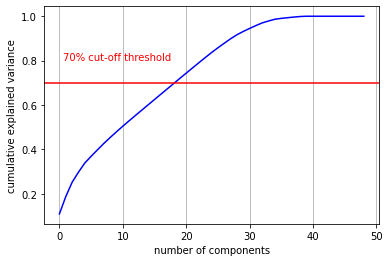

In [82]:
pca = PCA().fit(df_norm2)

fig, ax = plt.subplots()

plt.plot(np.cumsum(pca.explained_variance_ratio_), linestyle='-', color='b')

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.axhline(y = 0.70, color='r', linestyle='-')
plt.text(0.5, 0.80, '70% cut-off threshold', color = 'red', fontsize=10)

ax.grid(axis='x')
plt.show()

Based on the plot above, we can see how much variance is contained within the first N components. We can see that the first 20 principal components contain a little more than 70% of the variance of the data. When the number of components increases up to 40, the explained variance increases to 100%.

In [88]:
# # We could have also directly used the following command to perform PCA and keep at least 70% of the variance explained
# pca = PCA(n_components = 0.70)
# PC = pca.fit_transform(df_norm2)
# df_pca = pd.DataFrame(data = PC)
# df_pca.head()

In [90]:
# We want to keep more than 70% of the variability of the data, so we chose to use 20 PC's
pca = PCA(n_components = 20)
PC = pca.fit_transform(df_norm2)
df_pca = pd.DataFrame(data = PC, columns = ['PC ' + str(i+1) for i in range(20)])
df_pca.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20
0,0.864318,-0.187369,-1.640017,-4.086207,-7.455740,2.383562,0.367991,3.411897,0.239491,0.404152,0.126647,0.369059,1.013639,0.117527,-1.259830,-0.187435,0.047937,1.284684,-0.457731,0.707305
1,1.028077,-0.431588,-0.409511,-3.857492,-5.821624,5.907742,0.849591,2.917920,0.512301,0.589862,1.468597,0.214972,0.860167,-0.170282,-1.367498,-0.214912,-0.112598,1.227970,-0.762464,0.698497
2,2.606543,-2.375062,-2.635701,-3.887432,-6.598251,4.379106,-0.269224,2.699947,-0.118103,-0.144859,-1.205365,1.586199,1.018837,-0.522236,-0.792637,-0.091461,0.174394,1.063429,-0.481553,0.148834
3,0.812520,-0.230519,-1.889097,-3.991230,-6.866227,3.538452,0.615966,2.236713,1.202876,-1.596028,2.367407,0.419832,1.410830,-0.242610,-1.417836,-0.267602,-0.313335,1.361774,-0.626552,0.622307
4,0.615928,-0.278374,-2.644543,-3.752690,-5.713485,5.728087,0.687405,2.197437,0.596057,-0.236020,1.438949,1.270745,1.145902,-0.160801,-1.461189,-0.263088,-0.186986,1.419892,-0.490675,0.521360


In [91]:
# save the pca dataframe to a pickle file
df_pca.to_pickle('df_pca.pkl')

In [92]:
# the pre-processed data that we'll keep working with
df_pca = pd.read_pickle('df_pca.pkl')

### FAMD implemented with the prince library

In [93]:
# !pip install prince
import prince
import pprint

In [94]:
df_S = df_norm.copy()

In [95]:
# drop all missing values - they are not that many 
df_S.dropna(inplace=True)

By running FAMD several times, we saw that the fist 20 components contain a little more than 70% of the variance in the data. We got 20 PC's from the 1st method as well. So we transformed our dataset to 20 PC's using the famd function.

In [96]:
## Instantiate FAMD object
famd = prince.FAMD(
     n_components = 20,
     n_iter = 3,
     copy=True,
     check_input=True,
     engine='auto',       ## Can be "auto", 'sklearn', 'fbpca'
     random_state=42)

## Fit FAMD object to data 
famd = famd.fit(df_S)

In [97]:
print("Explained Variance: ", sum(famd.explained_inertia_))

Explained Variance:  0.7285818451538111


In [98]:
df_famd = famd.row_coordinates(df_S)
df_famd

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.688085,-0.109257,-0.760314,-3.392292,-2.613478,-1.501658,-0.484529,-1.354807,-0.067719,1.932949,0.256340,0.330689,-0.333378,0.819986,1.018502,0.144951,0.436024,-0.156337,0.107732,-0.212884
1,0.685142,-0.078100,-0.341570,-2.832113,-1.563940,-2.172447,-2.358823,-0.867813,-0.356547,1.821149,0.441991,0.666999,-0.072701,0.993981,1.046731,0.153604,0.448742,-0.103614,0.077127,-0.186948
2,1.884419,-1.448765,-1.697210,-2.971270,-1.990777,-2.397196,-1.245910,-1.231131,-0.953625,0.946360,-0.371858,-0.527808,0.305380,-0.159236,1.243719,0.249900,0.329527,-0.033507,0.212423,-0.288640
3,0.602750,-0.137907,-1.230387,-3.077228,-2.116356,-1.686839,-1.539544,-0.721695,0.107079,1.201428,1.270470,1.435092,0.696425,1.188335,1.270314,0.161503,0.511025,-0.236252,0.068137,-0.102063
4,0.491204,-0.125952,-1.302677,-2.858157,-1.731704,-2.024735,-2.296225,-0.557481,-0.077473,1.667458,0.494188,0.684997,-0.117030,0.983186,1.080859,0.112120,0.515143,-0.144610,0.120832,-0.190246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140103,-0.378554,0.025996,0.048054,1.305811,-0.916383,-0.292049,-0.232332,0.215882,0.763248,1.057451,1.778514,0.497612,-2.542769,-2.827699,0.342523,0.389233,-0.058661,0.547989,-1.370831,0.058534
140104,-0.358611,-0.064920,-0.333499,1.475650,-0.787611,-0.543871,0.894256,-0.596141,-0.779942,1.131919,1.793965,0.645037,-2.634111,-2.600095,0.252549,0.346369,-0.063332,0.544034,-1.381354,-0.004167
140105,-0.380045,-0.105070,-0.681272,1.662690,-0.509014,-0.170716,-0.705487,-1.268059,0.047374,1.113581,1.714507,0.506651,-2.452578,-2.684187,0.286025,0.394481,-0.134804,0.576717,-1.395091,0.058252
140106,0.679663,-1.283271,-1.149152,1.729312,-0.753628,0.421493,-0.365571,-0.631380,-1.820666,0.040653,1.700110,0.605236,-2.762740,-2.771737,0.228741,0.262543,-0.020561,0.513232,-1.308364,-0.120962


In [101]:
# renaming all the columns of the dataframe above
df_famd.columns = ['PC ' + str(i+1) for i in range(20)]

In [103]:
# the pre-processed data that we'll keep working with
df_famd.to_pickle('df_famd.pkl')

Each column stands for a factor component while each row stands a row in the original dataset. It is possible to display these projections with the following plot  with 2 components only because in this case the amount of components that we have at large scale cannot be represented:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:title={'center':'Row principal coordinates'}, xlabel='Component 0 (8.98% inertia)', ylabel='Component 1 (6.26% inertia)'>

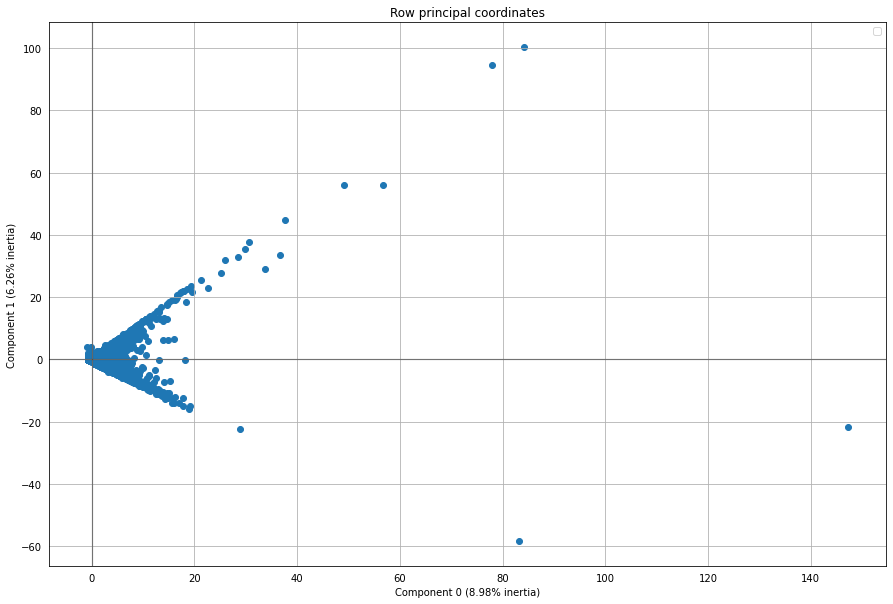

In [104]:
famd.plot_row_coordinates(df_S,ax= None, figsize=(15, 10),x_component=0, y_component=1, labels=None, ellipse_outline=False,ellipse_fill=True,show_points=True)

In [105]:
# import time

In [106]:
df_famd = pd.read_pickle('df_famd.pkl')

## 2.3 Clustering!

### 1. Implement the K-means clustering algorithm from scartch (not ++: random initialization).

#### Assumptions:
 >- we have a set of points with dimension equal to the number of components selected from the poijnt before;
 >- we consider the number of clusters 'K' fixed and given (we'll evaluate it later);
 >- let a centroid be the point   $$c_{j} = \frac 1 {|C_{j}|} \cdot \sum_{x \in C_{j}} x$$ 
 where $C_{j}$ is the j-th partition of the original set of points and $x$ is a vector (a point od dimension $d$);


#### Goal: 
find a partitioning $C = { {C_{1}, \cdot \cdot \cdot ,C_{K}} }$ , for $K \in N$, s.t. $$min \sum_{j = 1}^{K} \sum_{x \in C_{j}}^{K} ||x-c_{j}||^2$$ 
where:
>- $\sum_{x \in C_{j}}^{K} ||x-c_{j}||^2$ is the so called _residual sum of squares_ and it is a measure of how well a centroid represents the members of its cluster;
>- the objective function of the optimization problem is a sort of cost function dependent on the performance of the generated centroids. 


#### Implementation:
>- choose for first K different points (the K initial centroids);
>- assign each point to the cluster with the closest centroid;
>- evaluate the new centroids and reassign the points to the new clusters;
>- at each iteration the overall cost (in terms of distance as in the above formula) descreases and centroids converge to certain points;


We keep running the algortithm updating the values of the centroids until we achieve at least one of the 2 following conditions: 
1. at the _i-th_ iteration we have a convergence of the centroids around some values if: $$ \frac{||c_{j}^{(i)} - c_{j}^{(i-1)}||^2}{min_{l,j:i \neq j} ||c_{j}^{(i-1)} - c_{l}^{(i-1)}||^2} < \epsilon \space \space \space \space l,j = {1, \cdot \cdot \cdot, K}$$
For instance, if we choose $\epsilon = 0.02$, then iteration ceases when a complete iteration deos not move any of the cluster centroids by a distance of more than 2% of the smallest distance between any initial cluster centers;

2. if the algorithm does not converge we impose a stopping condition in terms of the maximum number of iterations.

In [107]:
class Kmeans:

    def __init__(self, k, dataframe, epsilon, n_iter):
        self.k = k
        self.dataframe = dataframe
        self.epsilon = epsilon
        self.n_iter = n_iter
        # initialize the first K centroids sampling "at random" K points from our dataset
        self.centroids =  self.dataframe.sample(self.k, replace= True, random_state=2424) # in this case we sample k rows from our data set since each row represents a point in our space
                                                                        # if we desire the reproducibility of the sample we should set the random_state of the sample
    
    # a function for the distance between each row of a dataframe and a vector (with the same dimension of the # of columns in the data frame)
    def euclidean_Dist(self, df1, df2):
        return np.linalg.norm(df1.values - df2.values, axis=1)


    # this function takes in input a dictionary representing the partitioning of the data set at a certain iteration of the algorithm
    # and returns the new centroids computed from the given clusters of points
    def compute_centr(self, part):
        clusters = {cl:[i for i in set(part.keys()) if part[i]==cl] for cl in set(part.values())}
        return [self.dataframe.iloc[clusters[cl]].sum()/len(self.dataframe.iloc[clusters[cl]]) for cl in clusters]

    def compute_inertia(self):
        clusters = self.compute_clusters()
        # evaluate all over the distances between each point and each centroid
        eu = np.array([self.euclidean_Dist(self.dataframe,c) for i,c in self.centroids.iterrows()])
        min_dist = [min([eu[j][i] for j in range(eu.shape[0])]) for i in range(eu.shape[1])]
        
        inertia = sum(min_dist)
        return inertia

    def compute_clusters(self):
        
        e = np.full((1, self.k), self.epsilon)
        
        # iteration counter
        i = 0
        while i<self.n_iter:

            # evaluating the eculidean distance between each point in the data frame and each centroid  
            eu = np.array([self.euclidean_Dist(self.dataframe,c) for i,c in self.centroids.iterrows()]) # j-th row of the eu matrix == the euclidean distance of each point from the j-th centroid 
                                                                                    # i-th column == i-th point of the data set
            # eu is a matrix with:
                # j rows that correspond to the number of centroids (# of clusters)
                # i columns that correspond to the number of points
            # we want to take the min value for each column i of the eu matrix that represents the distance between the i-th point with the closest centroid
            # we create a dictionary with a point as index and the centroid with the corresponding min distance as value                                                                           
            partitions = {i:j  for i in range(eu.shape[1]) for j in range(eu.shape[0]) if eu[j][i] == min([eu[j][i]  for j in range(eu.shape[0])])}

            # evaluate the new centroids given the clusters from the old centroids
            new_centroids = pd.DataFrame(self.compute_centr(partitions))

            # euclidean distance between the old centroids and the new centroids 
            numerator = self.euclidean_Dist(self.centroids, new_centroids)
            
            # the smallest distance between any initial cluster centers
            centr_density = np.array([self.euclidean_Dist(self.centroids,c) for i,c in self.centroids.iterrows()])[np.triu_indices(self.k, k = 1)] # we only want the upper triangle from the matrix of
                                                                                                                            # all possible distances between centroids
            # checking for convergence
            if  (numerator/min(centr_density) < e).all():
                # assigning the clusters in the sorted order
                print(f'The K-MEANS algorithm took {i} iterations to converge')
                self.centroids = new_centroids
                break
        
            # otherwise we update the centroids and we continue to the next iteration
            self.centroids = new_centroids
            i += 1    # when we go over the iteration limit we return the last clusters we found
            if i == self.n_iter -1:
                print("The algorithm reached the max number of iterations")
        
        clusters = list(partitions.values())
        return clusters


Check how the algorithm works. We try with 5 clusters.

In [108]:
strt = time.time()
clusters = Kmeans(5, df_famd, 0.002, 50).compute_clusters()
end = time.time()
print(f"Our implementation run in {round(end-strt,3)} seconds on python kernel")

The K-MEANS algorithm took 22 iterations to converge
Our implementation run in 46.717 seconds on python kernel


In [112]:
df_famd['cluster'] = clusters
df_famd.groupby('cluster')['PC 1'].count()

cluster
0    11549
1    12296
2    32992
3    40611
4    42186
Name: PC 1, dtype: int64

### MapReduce process

We report below the implemented algorithm according to the MapReduce logic implemented with PySpark on AWS EMR and then imported to this notebook. However, we noticed that the implementation with MapReduce is efficient but not effective, as it takes about 420% more time than the implementation on Python.

In [113]:
import numpy as np

Opening the text file from a s3 bucket

In [ ]:
data = sc.textFile('s3://hm3adm2022en/df_famd.csv')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Detecting the first row of the RDD since it only contains the names of the columns

In [ ]:
first = data.first()
first

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

',0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19'

Pre-processing our rdd with the set of points 

In [ ]:
data = data.filter(lambda row: row != first)\
.map(lambda row: row.split(','))\
.map(lambda row: (row[0], np.array(list(map(float, row[1:])))))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's visualize our starting RDD

In [ ]:
data.take(2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[('0', array([ 0.6930471 , -0.08759344, -0.76572498, -3.28359884, -2.76720775,
       -1.54212941, -0.36839888, -1.51248577, -0.19398863,  1.76477998,
        0.22640419, -0.2382897 , -0.26972114,  1.23016473,  0.69485667,
        0.16197169,  0.33567271,  0.20606286,  0.04499939,  0.15311358])), ('1', array([ 0.69072549, -0.06140763, -0.34981673, -2.76228651, -1.67379327,
       -2.25114206, -2.2334135 , -1.16626371, -0.50907629,  1.62092996,
        0.46057031, -0.36040981,  0.03750278,  1.43996907,  0.74731307,
        0.14276285,  0.33464287,  0.23418544,  0.07670302,  0.11944318]))]

Now we proceed in implementing an algorithm for the k-means that works exactly like the algorithm implemented in python with only two big differences:

>- the k-means functions returns a list of key-value pairs, where the key is the cluster and the value is a list with the indexes of all the points of the corresponding cluster;
>- the most of the operations are now divided in tasks of Mapping and Reducing,parallelizing the computation.

In [114]:
def euclidean_dist(x, y):
    return np.linalg.norm(x-y)

# function to compute the new centroids -> it takes in input the old centroids (a list of arrays) and an RDD with all over the points
def compute_centr(data, old_centr):
    new_centr = data.map(lambda row : (np.argmin([euclidean_dist(row[1], c) for c in old_centr]), row[1]))\
                    .aggregateByKey((0,0), lambda a,b: (a[0] + b, a[1] + 1),lambda a,b: (a[0] + b[0], a[1] + b[1]))\
                    .map(lambda row: row[1][0]/row[1][1]).collect()
    return new_centr

def kmeans(data, k, epsilon, n_iter):
    
    e = np.full((1,k), epsilon)
    
    # initializing the centroids
    centroids = [i[1] for i in data.takeSample(False,k)]
    # start with the iterations unitl a max number of iterations
    i=0
    while i<n_iter:
        
        # computing the new centroinds 
        new_centroids = compute_centr(data, centroids)
        
        # evaluating the stopping condition
        # start from the roght term of the diequality
        numerator = np.array([euclidean_dist(c, nc) for c, nc in zip(centroids, new_centroids)])
        centr_density = np.array([[euclidean_dist(c1,c2) for c1 in centroids] for c2 in centroids])[np.triu_indices(k, k = 1)]
        if  (numerator/min(centr_density) < e).all():
            # assigning the cluster to each point
            print(f'The K-MEANS algorithm took {i} iterations to converge')
            centroids = new_centroids
            break
        # updating the centroids
        centroids = new_centroids
        i += 1
        
    # assigning each point to the corresponding cluster
    clusters = data.map(lambda row : (np.argmin([euclidean_dist(row[1], c) for c in new_centroids]), row[0]))\
                    .reduceByKey(lambda a,b: a+" "+b)\
                    .map(lambda row: {row[0]: row[1].split()})\
                    .collect()
    return clusters   

In [ ]:
# example
part = kmeans(data, 4, 0.002, 30)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 2. Find an optimal number of clusters.

#### Elbow method

In order to evaluate the optimal number of clusters we use for first the Elbow Method:

>- we measure the quality of the cluster for different number of clusters K;
>- in this case we report a plot of the so called _inertia_ given different values of K, where the _inertia_ or the _within-cluster sum-of-squares_ criterion is the same reported by the built-in function in sickit learn: $$WCSS=\sum_{j=1}^{K} \sum_{x \in C_{j}} ||x-c_{j}||^2$$
>- we want to minimize the above function but without using too many clusters, so we are going to find a correct K that correctly satisfies the trade-off between number of clusters and quality of the clusters.

Below we implement a function to find the WCSS given a certain partitioning and number of clusters.

When approaching the calculation of the optimal K we prefer to use the algorithm implemented on python as it is much more performant. In fact, as noted by the from scratch implementation of the elbow method, we have to call Kmeans multiple times to study how the clustering quality varies as K varies.

In [ ]:
elbow = []

for i in range(3,31,3):
    print(f"For K ={i}")
    elbow.append(Kmeans(i, df_famd, 0.002, 25).compute_inertia())

For K =3
The K-MEANS algorithm took 16 iterations to converge
For K =6
The algorithm reached the max number of iterations
For K =9
The algorithm reached the max number of iterations
For K =12
The algorithm reached the max number of iterations
For K =15
The algorithm reached the max number of iterations
For K =18
The K-MEANS algorithm took 23 iterations to converge
For K =21
The algorithm reached the max number of iterations
For K =24
The algorithm reached the max number of iterations
For K =27
The algorithm reached the max number of iterations
For K =30
The algorithm reached the max number of iterations


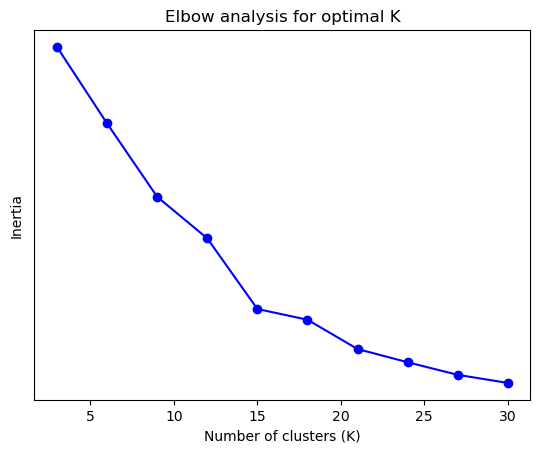

In [ ]:
plt.plot(range(3,31,3), elbow, 'bo-')
plt.yticks([])
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow analysis for optimal K')
plt.show()

From the plot above, we can see that the optimal number of clusters for our data is **15**.

#### Silhouette method
The silhouette coefficient or silhouette score kmeans is a measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation).
The equation for calculating the silhouette coefficient for a particular data point:

$$S(i)= b(i) - a(i) / max (a(i), b(i))$$

>- $S(i)$ is the silhouette coefficient of the data point i.
>- $a(i)$ is the average distance between i and the other point in the SAME cluster
>- $b(i)$ is the minimum average distance from i to all the centroids of the OTHER clusters
    
The value of the silhouette coefficient is between [-1, 1]. A score of 1 denotes the best meaning that the data point i is very compact within the cluster to which it belongs and far away from the other clusters. The worst value is -1. Values near 0 denote overlapping clusters.

In [ ]:
# inputs of silhouette samples function
def euclidean_Dist(df1, df2):
        return np.linalg.norm(df1.values - df2.values, axis=0)

distances = [[euclidean_Dist(row_a, row_b) for i, row_b in df_famd.iterrows()] for j, row_a in df_famd.iterrows()]
distances = np.array(distances)

In [6]:
labels = []
for i in range(3,31,3):
    print(f"For K ={i}")
    strt = time.time()
    labels.append(Kmeans(i, df_famd, 0.002, 25).compute_clusters())
    end = time.time()
    print(f"Our implementation run in {round(end-strt,3)} seconds on python kernel")

For K =3
The K-MEANS algorithm took 16 iterations to converge
Our implementation run in 10.557 seconds on python kernel
For K =6
The algorithm reached the max number of iterations
Our implementation run in 38.136 seconds on python kernel
For K =9
The algorithm reached the max number of iterations
Our implementation run in 72.087 seconds on python kernel
For K =12
The algorithm reached the max number of iterations
Our implementation run in 114.191 seconds on python kernel
For K =15
The algorithm reached the max number of iterations
Our implementation run in 163.949 seconds on python kernel
For K =18
The K-MEANS algorithm took 23 iterations to converge
Our implementation run in 216.224 seconds on python kernel
For K =21
The algorithm reached the max number of iterations
Our implementation run in 293.941 seconds on python kernel
For K =24
The algorithm reached the max number of iterations
Our implementation run in 370.521 seconds on python kernel
For K =27
The algorithm reached the max nu

In [ ]:
from sklearn.metrics import silhouette_samples
# get silhouette
silhouette_vals = silhouette_samples(distances,labels)

In [ ]:
# Get the average silhouette score
avg_score = np.mean(silhouette_vals)
ax[0].axvline(avg_score,linestyle ='--',
              linewidth =2,color = 'green')
ax[0].set_yticks([])
ax[0].set_xlim([-0.1, 1])
ax[0].set_xlabel('Silhouette coefficient values')
ax[0].set_ylabel('Cluster labels')
ax[0].set_title('Silhouette plot for the various clusters')

### 3. Run the algorithm on the data

Once we found the optimal number K of clusters we proceed with the implementation of the MapReduce Kmeans.

In [ ]:
start = time.time()
part = kmeans(data, 15, 0.002, 30)
end = time.time()
print(f'The mapReduce implementation of Kmeans took {round(end-start,2)} seconds')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The mapReduce implementation of Kmeans took 280.04 seconds

In [ ]:
for i in range(len(part)):
    print(f'The cluster number {i} contains {len(list(part[i].values())[0])} points')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The cluster number 0 contains 13281 points
The cluster number 1 contains 5837 points
The cluster number 2 contains 10087 points
The cluster number 3 contains 22379 points
The cluster number 4 contains 3043 points
The cluster number 5 contains 9741 points
The cluster number 6 contains 15 points
The cluster number 7 contains 1213 points
The cluster number 8 contains 10737 points
The cluster number 9 contains 21620 points
The cluster number 10 contains 11830 points
The cluster number 11 contains 7322 points
The cluster number 12 contains 9021 points
The cluster number 13 contains 10551 points
The cluster number 14 contains 2957 points

### 4. Then, use the already implemented version of K-means++ (from the scikit-learn library). Explain the differences (if there are any) in the results.

In [115]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

We decided to run the algorithm on the dataset from PCA

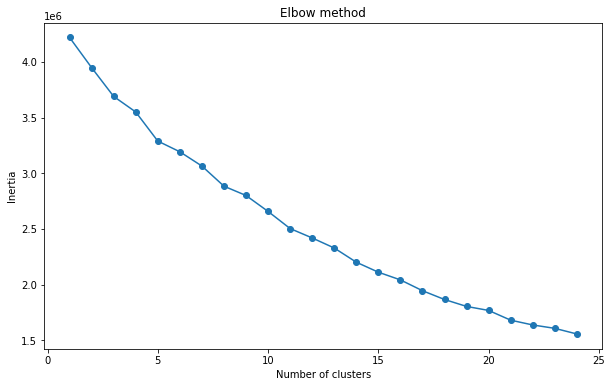

In [116]:
inertias = []

for i in range(1,25):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(df_pca)
    inertias.append(kmeans.inertia_)

plt.figure(figsize = (10,6))
plt.plot(range(1,25), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [117]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 25), inertias, curve="convex", direction="decreasing")
kl.elbow

14

The elbow method, plots the number of clusters and the inertia. As we increase the number of clusters, the inertia decreases. As more centroids are added, the distance from each point to its closest centroid decreases. Therefore, the SSE decreases.

The elbow point is where the SSE curve starts to bend. Its x-value indicates the optimal number of clusters. It is thought to be a reasonable trade-off between error and number of clusters. 

We could have also used the yellowbrick version to find the optimal number of clusters.

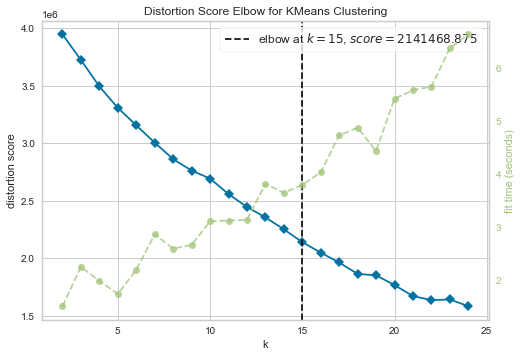

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [118]:
# here, we run KMeans on the dataset from PCA
# Elbow Method for K means

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(init='k-means++')

# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,25), timings= True)
visualizer.fit(df_pca)
visualizer.show()       

Here, we get 15 clusters (1 more than the clusters from the above plot).

We also got 15 clusters from our version of the elbow method (the one we implemented from scratch).

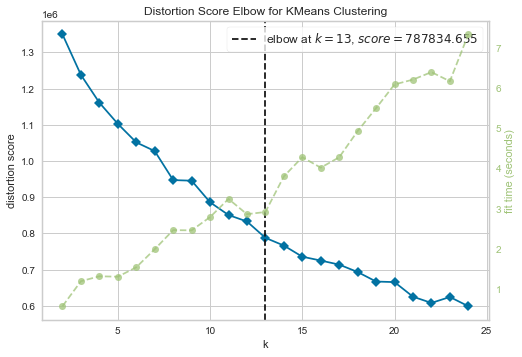

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [119]:
# here, we run KMeans on the dataset from FAMD
# Elbow Method for K means

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(init='k-means++')

# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,25), timings= True)
visualizer.fit(df_famd)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

We ran the KMeans clustering on both datasets that we got from PCA and FAMD. There was a slight difference between the number of optimal clusters.
- For df_pca, we got optimal 15 clusters.
- For df_famd, the optimal number of clusters was 13.

Another metric for finding the optimal number of clusters is the silhouette coefficient. The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
- How close the data point is to other points in the cluster
- How far away the data point is from points in other clusters

The SC is in the range [-1, 1]. Larger numbers indicate that points are closer to their clusters than they are to other clusters.
- SC=0 indicates that clusters are significantly overlapping one another
- SC=1 indicates clusters are well-separated

Using the yellowbrick version

In [ ]:
# Silhouette Score for K means

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(init='k-means++')

# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,25),metric='silhouette', timings= True)
visualizer.fit(df_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

We finally decided to move on with the dataset from PCA and group the data into 15 different clusters.

# 4. Analysing your results!
You are often encouraged to explain the main characteristics that your clusters have. This is called the Characterizing Clusters step. Thus, follow the next steps to do it:

1. Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, CustGender, Number of transactions, etc.

2. Most of your selected variables will be numerical (continuous or discrete), then categorise them into four categories.

3. With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

4. Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100. The sample example for clustering with K = 4 and Gender variable.

5. Interpret the results for each pivot table.

6. Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?).

In [120]:
kmeans = KMeans(n_clusters=15)
clusters = kmeans.fit_predict(df_pca)

In [121]:
df_pca_clusters = df_pca.copy()
df_pca_clusters['Clusters'] = clusters 

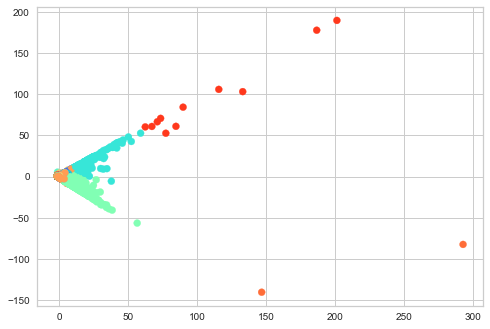

In [125]:
# plot the clusters 
plt.scatter(df_pca_clusters['PC 1'], df_pca_clusters['PC 2'], c = df_pca_clusters['Clusters'], cmap='rainbow')

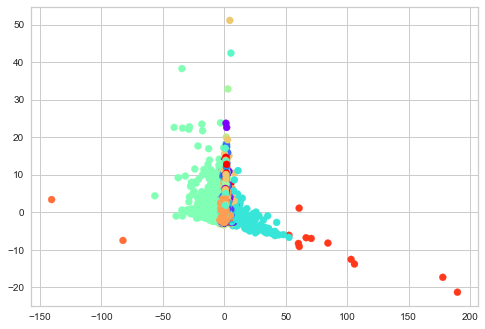

In [126]:
# plot the clusters
plt.scatter(df_pca_clusters['PC 2'], df_pca_clusters['PC 3'], c = df_pca_clusters['Clusters'], cmap='rainbow')

There are many clusters (15) in order to plot all of them and be able to easily see them.
Here, we have plotted the 1st & 2nd and 2nd & 3rd Principal Components. We can easily see several of the clusters. There are 3-4 clusters (red,orange,light blue,green) that we can easily see.

Add the clusters as a new column to the dataset (the df before normalizing the features)

In [127]:
df4 = pd.read_pickle('df4_final.pkl')
df4.replace([np.inf, -np.inf], np.nan, inplace=True)
df4.dropna(inplace=True)
df4.shape

(139634, 28)

In [128]:
df4_clusters = df4.copy()
df4_clusters['Clusters'] = clusters 

In [130]:
# now we have a dataset which contains all the info about each customer and their corresponding cluster group
df4_clusters.head()

,CustomerDOB,Num_Trans,Num_Trans_Weekend,Num_Trans_100USD,Have_Trans_Birthday,Have_Trans_Christmas,Have_Trans_Diwali,Avg_TransAmountUSD,Max_TransAmountUSD,Min_TransAmountUSD,...,Age_Class,CustDOB_Month,ZodiacSign,Cust_Type,AvgBalance>AvgSalary,In_Top10RichCities,Ratio_AccBal,Ratio_AccBal_FM,Ratio_TransAmnt_FM,Clusters
0,1901-01-01,1,0,0,0,1,0,0.05688,0.05688,0.05688,...,retired,1,Capricorn,silver,1,1,8.093586e-07,1.105648e-06,2.676186e-08,9
1,1901-01-01,8,2,0,0,1,1,40.27275,90.64800,2.78400,...,retired,1,Capricorn,bronze,0,1,1.582293e-08,2.161537e-08,1.894820e-05,9
2,1901-01-01,1,0,0,0,1,0,69.48000,69.48000,69.48000,...,retired,1,Capricorn,bronze,1,0,1.684668e-07,2.301390e-07,3.269012e-05,9
3,1901-01-05,4,1,0,0,1,0,4.09800,7.80000,1.68000,...,retired,1,Capricorn,bronze,1,1,3.706124e-08,5.062859e-08,1.928096e-06,9
4,1901-01-07,2,1,0,0,0,0,4.79400,7.20000,2.38800,...,retired,1,Capricorn,bronze,0,0,9.947302e-09,1.358880e-08,2.255562e-06,9


In our opinion, some of the important variables for the clusters are Number of Transactions, Average Transaction Amount in USD, and Cusotmer Class based on age (young, working, retired), so we decided to further analyze those features. 

Number of Transactions and Average Transaction Amount in USD are numerical features, so we categorize the customers into 4 groups based on each of the two features.

In [139]:
# Num Transactions - Num Customers
# 1 - 34783
# (1,5) - 44507
# (5,10) - 28751
# >100 - 28291

# function that creates 4 different categories based on the Number of Transactions that the customers made
def NumTrans_Cat(num_tr):
    if num_tr == 1:
        return 'NumTr 1'  
    elif num_tr < 5:
        return 'NumTr (1,5)'
    elif num_tr < 10:
        return 'NumTr (5,10)'
    else:
        return 'NumTr >10'

# apply the function to our data - classify each customer into one of the 4 groups
df4_clusters['NumTrans_Cat'] = df4_clusters['Num_Trans'].apply(lambda row: NumTrans_Cat(row))

In [140]:
# Avg Trans Amnt - Num Customers
# <5 - 41888
# (5,10) - 31330
# (10,20) - 31856
# >20 - 34553


# function that creates 4 different categories based on the Average Trans Amount
def TransAmnt_Cat(trans_amnt):
    if trans_amnt < 5:
        return 'AvgAmnt <5'  
    elif trans_amnt < 10:
        return 'AvgAmnt (5,10)' 
    elif trans_amnt < 20:
        return 'AvgAmnt (10,20)' 
    else:
        return 'AvgAmnt >20' 

# apply the function to our data - classify each customer into one of the 4 groups
df4_clusters['AvgTransAmnt_Cat'] = df4_clusters['Avg_TransAmountUSD'].apply(lambda row: TransAmnt_Cat(row))

In [141]:
df4_clusters.head(2)

,CustomerDOB,Num_Trans,Num_Trans_Weekend,Num_Trans_100USD,Have_Trans_Birthday,Have_Trans_Christmas,Have_Trans_Diwali,Avg_TransAmountUSD,Max_TransAmountUSD,Min_TransAmountUSD,...,ZodiacSign,Cust_Type,AvgBalance>AvgSalary,In_Top10RichCities,Ratio_AccBal,Ratio_AccBal_FM,Ratio_TransAmnt_FM,Clusters,NumTrans_Cat,AvgTransAmnt_Cat
0,1901-01-01,1,0,0,0,1,0,0.05688,0.05688,0.05688,...,Capricorn,silver,1,1,8.093586e-07,1.105648e-06,2.676186e-08,9,NumTr 1,AvgAmnt <5
1,1901-01-01,8,2,0,0,1,1,40.27275,90.64800,2.78400,...,Capricorn,bronze,0,1,1.582293e-08,2.161537e-08,1.894820e-05,9,"NumTr (5,10)",AvgAmnt >20


In [142]:
# keep only the 3 variables we are interested in
df_Clust = df4_clusters[['NumTrans_Cat','AvgTransAmnt_Cat','Age_Class','Clusters']]
df_Clust.head()

,NumTrans_Cat,AvgTransAmnt_Cat,Age_Class,Clusters
0,NumTr 1,AvgAmnt <5,retired,9
1,"NumTr (5,10)",AvgAmnt >20,retired,9
2,NumTr 1,AvgAmnt >20,retired,9
3,"NumTr (1,5)",AvgAmnt <5,retired,9
4,"NumTr (1,5)",AvgAmnt <5,retired,9


#### Pivot Tables

Our clusters were made based on all variables and the three that we chose for pivot tables do not seem to divide the customers very well

In [143]:
pivot_table_11 = pd.pivot_table(data = df_Clust, 
                               index=['Clusters'],
                               columns=['NumTrans_Cat'],
                               values='Age_Class',
                               aggfunc='count', margins=True, 
                               dropna=True, fill_value=0)

In [144]:
#pivot_table_11

In [145]:
pivot_table_12 = pivot_table_11.div(pivot_table_11.iloc[:,-1], axis=0)
pivot_table_12.drop('All', axis=1, inplace=True)
pivot_table_12 = pivot_table_12.multiply(100)
pivot_table_12

NumTrans_Cat,"NumTr (1,5)","NumTr (5,10)",NumTr 1,NumTr >10
Clusters,,,,
0,31.867684,21.302799,24.284987,22.544529
1,32.302923,20.510613,24.531795,22.654669
2,32.654476,20.426380,24.742179,22.176965
3,31.504501,21.697385,23.900557,22.897557
4,31.931008,20.741718,24.606665,22.720610
5,31.428571,22.380952,24.761905,21.428571
6,32.209194,21.375947,23.409775,23.005085
7,28.481013,15.119550,42.158931,14.240506
8,32.573479,20.777961,24.260355,22.388204


In [146]:
pivot_table_21 = pd.pivot_table(data = df_Clust, 
                               index=['Clusters'],
                               columns=['AvgTransAmnt_Cat'],
                               values='Age_Class',
                               aggfunc='count', margins=True, 
                               dropna=True, fill_value=0)

In [147]:
#pivot_table_21

In [148]:
pivot_table_22 = pivot_table_21.div(pivot_table_21.iloc[:,-1], axis=0)
pivot_table_22.drop('All', axis=1, inplace=True)
pivot_table_22 = pivot_table_22.multiply(100)
pivot_table_22

AvgTransAmnt_Cat,"AvgAmnt (10,20)","AvgAmnt (5,10)",AvgAmnt <5,AvgAmnt >20
Clusters,,,,
0,22.992366,22.351145,31.857506,22.798982
1,22.740776,23.098119,31.235200,22.925905
2,22.116301,23.884219,32.160499,21.838981
3,23.189027,23.137591,31.273039,22.400343
4,23.859083,23.267859,30.577543,22.295515
5,14.285714,7.619048,15.238095,62.857143
6,24.322922,22.600394,29.729169,23.347515
7,0.000000,0.000000,0.000000,100.000000
8,23.833544,22.882918,30.041711,23.241828


In [149]:
pivot_table_31 = pd.pivot_table(data = df_Clust, 
                               index=['Clusters'],
                               columns=['Age_Class'],
                               values='NumTrans_Cat',
                               aggfunc='count', margins=True, 
                               dropna=True, fill_value=0)

In [150]:
#pivot_table_31

In [151]:
pivot_table_32 = pivot_table_31.div(pivot_table_31.iloc[:,-1], axis=0)
pivot_table_32.drop('All', axis=1, inplace=True)
pivot_table_32 = pivot_table_32.multiply(100)
pivot_table_32

Age_Class,retired,working,young
Clusters,,,
0,0.000000,100.000000,0.000000
1,0.000000,99.991389,0.008611
2,0.000000,100.000000,0.000000
3,0.000000,100.000000,0.000000
4,0.000000,100.000000,0.000000
5,19.047619,80.476190,0.476190
6,0.000000,98.619902,1.380098
7,8.052039,91.561181,0.386779
8,0.000000,100.000000,0.000000


# Algorithmic Question

In [152]:
N, M , G = list(map(int, input().split()))

4 5 1


In [153]:
students = list(map(int, input().split()))

1 1 3 3 3


In [154]:
guards = 1
for i in range(1, len(students)):
    if (students[i] != students[i-1]) and (students[i] not in students[:i]) :
        if students[i-1] in students[i+1:]:
            guards += 1

print(guards <= G)
print(guards)

True
1
